# 2º Parte: Proyecto de análisis y gestión de recursos aeroportuarios del Aeroparque Jorge Newbery

### Big Data Bang: explosionando las rutas aéreas para predecir un caos en alto vuelo.
---


Grupos de trabajo:
* Joaquin Barrionuevo
* Sebastián Coca
* Sabrina Gonzalez del Campo

## Instalación y actualización de librerías a utilizar en el desarrollo del proyecto

In [1]:
#@title Instalación de librerías externas
!pip install -q pingouin
!pip install calmap
!pip install july
!pip install geopandas
#!pip install -q folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pingouin as pg
import calmap
import july
import geopandas

import folium  #needed for interactive map
from folium.plugins import HeatMap

In [3]:
#@title Carga de librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import datetime
import warnings

#import missingno as msno
#import pingouin as pg
import plotly.express as px
#from ydata_profiling import ProfileReport
import matplotlib.colors as mcolors

from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier  #arbol de decision
from sklearn import tree #arbol de decision
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from geopy.distance import geodesic
from tabulate import tabulate
#import matplotlib.dates as mdates

In [4]:
use_drive = True
if (use_drive):
  from google.colab import drive
  drive.mount('/content/drive')
  # guardado de la DB en el drive
  path = '/content/drive/Shared drives/M08-BigDataBang/'

Mounted at /content/drive


In [5]:
# Carga de parámetros
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lectara y curación de los dataset

In [6]:
#@title Lectura del dataset

fechas = ['Horario_Prog_Arribo', 'Horario_Estimado_Arribo', 'Horario_Actual_Arribo']     # para que lea como datetime
url = "https://raw.githubusercontent.com/sebascoca/M08-BDB/main/TP1/Base_Final_TP1.csv"

df = pd.read_csv(url, parse_dates = fechas)

# Volvemos a los nombres originarios de las columnas y unas nuevas
df.rename(columns={
    'Nombre_Aerolinea' : 'Aero', # '4M' '5U' 'A0' 'AJ' 'AR' 'AU' 'DN' 'FAA' 'FO' 'FQ' 'G3' 'H2' 'H8' 'JA', 'LA' 'LP' 'OY' 'PRV' 'USF' 'VH' 'WJ' 'Z7' 'ZP'
    'Codigo_Vuelo' : '#Vuelo',
    'Ruta_Vuelo' : 'Origen',
    'Horario_Prog_Arribo' : 'STA',
    'Horario_Estimado_Arribo' : 'ETA',
    'Horario_Actual_Arribo' : 'ATA',
    'Tipo_Vuelo' : 'Tipo',                     # Asume el valor "1 C P" en el 80% de los casos
    'Posicion_Arribo' : 'Pos',
    'Terminal_Arribo' : 'Ter',
    'Sector' : 'Sec',
    'Estado_Vuelo' : 'Rmk',                    # Ate: aterrizado (tierra), Can: Cancelado, Alt: Altura (aire)
    'Cinta_Equipajes' : 'Cin',
    'Cant_Pasajeros' : 'Pax',
    'Matricula_Aeronave' : 'Mat',
    'Tipo_Aeronave' : 'Acft',
    'Nombre_Aerolinea_Partida' : 'Aero.1',
    'Vuelo_Partida' : '#Rot',
    'Cabecera_Arribo' : 'Cabecera',
    'Año_Vuelo' : 'año',
    'Mes_Vuelo' : 'mes',
    'Hora_Vuelo' : 'hora',
    'Pais_Aeropuerto' : 'country',
    'Ciudad_Aeropuerto' : 'city',
    'Latitud_Aeropuerto' : 'lat',
    'Longitud_Aeropuerto' : 'lon',
    'Capacidad_Max_Aeronave' : 'max_cap',
    'Uso_Aeronave' : 'uso',
    },
    inplace = True)

df

,Aero,#Vuelo,Origen,STA,ETA,ATA,Tipo,Pos,Ter,Sec,Rmk,Cin,Pax,Mat,Acft,Aero.1,#Rot,Cabecera,año,mes,hora,country,city,lat,lon,max_cap,uso
0,DN,6049,IGR,2019-01-01 01:50:00,2019-01-01 01:22:00,2019-01-01 01:22:00,1 C P,31,A,2,ATE,8,100.00,LVHQH,738,DN,6062,31.00,2019,1,1,Argentina,Puerto Iguazú,-25.74,-54.47,189,Transporte de pasajeros
1,4M,7623,COR,2019-01-01 06:17:00,2023-07-07 05:50:00,2019-01-01 06:02:00,1 C P,9,A,2,ATE,6,36.00,LVBFO,320,4M,7502,31.00,2019,1,6,Argentina,Córdoba,-31.31,-64.21,180,Transporte de pasajeros
2,4M,7653,MDZ,2019-01-01 07:37:00,2023-07-07 07:30:00,2019-01-01 07:30:00,1 C P,10,A,2,ATE,8,153.00,LVGLP,320,4M,7550,13.00,2019,1,7,Argentina,Mendoza,-32.83,-68.79,180,Transporte de pasajeros
3,AR,1671,NQN,2019-01-01 07:40:00,2023-07-07 07:29:00,2019-01-01 07:26:00,1 C P,7,A,2,ATE,1,28.00,LVFUA,738W,AR,1672,13.00,2019,1,7,Argentina,Neuquén,-38.95,-68.16,189,Transporte de pasajeros
4,AR,1611,MDQ,2019-01-01 07:55:00,2023-07-07 07:45:00,2019-01-01 07:43:00,1 C P,26,A,2,ATE,2,146.00,LVGVA,738W,AR,1496,13.00,2019,1,7,Argentina,Mar del Plata,-37.93,-57.57,189,Transporte de pasajeros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125583,WJ,3481,SLA,2022-09-30 22:08:00,2023-07-07 22:03:00,2022-09-30 22:05:00,1 C P,17,A,N,ATE,9,187.00,LVKDP,320,WJ,3266,13.00,2022,9,22,Argentina,Salta,-24.01,-65.45,180,Transporte de pasajeros
125584,JA,1003,SCL,2022-09-30 22:15:00,2022-09-30 22:32:00,2022-09-30 22:32:00,1 I P,68,A,I,ATE,3,150.00,CCAWQ,320N,JA,1004,13.00,2022,9,22,Chile,Santiago de Chile,-33.39,-70.79,180,Transporte de pasajeros
125585,WJ,3269,COR,2022-09-30 22:21:00,2023-07-07 22:01:00,2022-09-30 22:02:00,1 C P,16,A,N,ATE,7,163.00,LVHVT,320,WJ,3461,13.00,2022,9,22,Argentina,Córdoba,-31.31,-64.21,180,Transporte de pasajeros
125586,FO,5225,TUC,2022-09-30 23:25:00,2023-07-07 23:20:00,2022-09-30 23:15:00,1 C P,66,A,N,ATE,8,178.00,LVKAY,738W,FO,5042,13.00,2022,9,23,Argentina,San Miguel de Tucumán,-26.84,-65.10,189,Transporte de pasajeros


### Arreglo y/o correcciones varias en el dataset

In [7]:
#@title Correción de errores detectados en las columnas "city"; "country"

ver = df[df['Origen'].isin(['RCU', 'LPG', 'GNR', 'VLG'])]
print('Ubicaciones erróneas detectadas en las columnas city y country:\n')

display(ver.city.unique())
display(ver.country.unique())

corregir = ['RCU', 'LPG', 'GNR', 'VLG']
city_ok = ['Río Cuarto', 'La Plata', 'General Roca', 'Villa Gesell']

for i in range(len(corregir)):
    df.loc[df['Origen'] == corregir[i], 'city'] = city_ok[i]
    df.loc[df['Origen'] == corregir[i], 'country'] = 'Argentina'

Ubicaciones erróneas detectadas en las columnas city y country:



array(['Rafha', 'Ciudad del Este', 'Gavião', 'Vilhena'], dtype=object)

array(['Arabia Saudita', 'Paraguay', 'Portugal', 'Brasil'], dtype=object)

In [8]:
#@title Curado del dataset
# verificamos los tipos, cantidades y correcciones
#print(df.info())  # no toma los temporales como corresponde, se corrije al leer el dataset

# eliminamos Aero.1 (217 difieren de Aero) y evitamos excepción por error
try:
  df.drop(columns = 'Aero.1', inplace = True) #, errors = 'ignore')
except KeyError:
  print('\nWARNING: La columna Aero.1 ya fue borrada en una corrida previa de la celda o no existe en el dataset\n')

# corrección del tipo para pasajeros
df['Pax'] = df['Pax'].astype(int)

# corrección del tipo para max_cap (Capacidad máxima del vuelo), asignación en caso que sea "Variable" a -1 y luego a entero
# cam = {'Variable' : '-1'} # se puede usar dict
df['max_cap'].replace( to_replace='Variable', value='-1', inplace=True )
df['max_cap'] = df['max_cap'].astype(int)

# Corrección de la fecha para ETA
df['ETA'] = df.apply(lambda row: row['ETA'].replace(
    year = row['ATA'].year,
    month = row['ATA'].month,
    day = row['ATA'].day),
    axis=1)

# se utiliza para el merge con lo del clima
columnas_df = df.columns

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125588 entries, 0 to 125587
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Aero      125588 non-null  object        
 1   #Vuelo    125588 non-null  object        
 2   Origen    125588 non-null  object        
 3   STA       125588 non-null  datetime64[ns]
 4   ETA       125588 non-null  datetime64[ns]
 5   ATA       125588 non-null  datetime64[ns]
 6   Tipo      125588 non-null  object        
 7   Pos       125588 non-null  object        
 8   Ter       125588 non-null  object        
 9   Sec       125588 non-null  object        
 10  Rmk       125588 non-null  object        
 11  Cin       125588 non-null  int64         
 12  Pax       125588 non-null  int64         
 13  Mat       125588 non-null  object        
 14  Acft      125588 non-null  object        
 15  #Rot      125588 non-null  object        
 16  Cabecera  125588 non-null  float64    

In [9]:
#@title Casos particulares para analizar
#print(f'vuelo raro... {df1[df1["#Vuelo"] == "ZTO"]}' )
#df['Cabecera'].unique()
#print(f'\n\nProblemas con estos vuelos... {df1[df["Pax"] >= df1["max_cap"]]}' )

print(f'Analizar estos casos: \n',
      f'caso 1: En #Vuelo todos son números menos ZTO que tiene {len(df[df["#Vuelo"] == "ZTO"])} elemento \n',
      f'caso 2: Hay {len(df[df["Pax"] > df["max_cap"]])} casos donde la capacidad máxima (max_cap) es INFERIOR al número de pasajeros por vuelo (Pax) \n'
      )
df[df["Pax"] > df["max_cap"]]

Analizar estos casos: 
 caso 1: En #Vuelo todos son números menos ZTO que tiene 1 elemento 
 caso 2: Hay 3355 casos donde la capacidad máxima (max_cap) es INFERIOR al número de pasajeros por vuelo (Pax) 



,Aero,#Vuelo,Origen,STA,ETA,ATA,Tipo,Pos,Ter,Sec,Rmk,Cin,Pax,Mat,Acft,#Rot,Cabecera,año,mes,hora,country,city,lat,lon,max_cap,uso
49,OY,861,BRC,2019-01-01 14:45:00,2019-01-01 15:30:00,2019-01-01 15:12:00,1 C P,31,A,2,ATE,8,129,LVBEG,M83,860,13.00,2019,1,14,Argentina,San Carlos de Bariloche,-41.15,-71.16,86,Transporte de pasajeros
73,OY,551,PMY,2019-01-01 17:00:00,2019-01-01 16:50:00,2019-01-01 16:59:00,1 C P,31,A,2,ATE,8,126,LVWGM,M81,590,13.00,2019,1,17,Argentina,Puerto Madryn,-42.76,-65.10,105,Transporte de pasajeros
124,OY,591,PDP,2019-01-01 21:30:00,2019-01-01 22:15:00,2019-01-01 22:13:00,4 R P,30,A,I,ATE,1,128,LVWGM,M81,570,31.00,2019,1,21,Uruguay,Punta del Este,-34.86,-55.09,105,Transporte de pasajeros
153,OY,893,COR,2019-01-02 00:55:00,2019-01-02 02:33:00,2019-01-02 02:33:00,1 C P,67,A,2,ATE,8,159,LVAYD,M83,AYD,31.00,2019,1,0,Argentina,Córdoba,-31.31,-64.21,86,Transporte de pasajeros
158,OY,852,JUJ,2019-01-02 04:00:00,2019-01-02 06:36:00,2019-01-02 06:36:00,1 C P,9,A,2,ATE,8,140,LVBEG,M83,BEG,31.00,2019,1,4,Argentina,San Salvador de Jujuy,-24.39,-65.10,86,Transporte de pasajeros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125459,WJ,3243,MDZ,2022-09-30 00:39:00,2022-09-30 00:28:00,2022-09-30 00:28:00,1 C P,16,A,N,ATE,9,185,LVKFX,320,3240,13.00,2022,9,0,Argentina,Mendoza,-32.83,-68.79,180,Transporte de pasajeros
125481,WJ,3241,MDZ,2022-09-30 10:02:00,2022-09-30 09:57:00,2022-09-30 09:52:00,1 C P,7,A,N,ATE,8,182,LVKFX,320,3500,13.00,2022,9,10,Argentina,Mendoza,-32.83,-68.79,180,Transporte de pasajeros
125485,WJ,3445,NQN,2022-09-30 10:27:00,2022-09-30 10:11:00,2022-09-30 10:11:00,1 C P,18,A,N,ATE,8,194,LVJQE,320,3266,13.00,2022,9,10,Argentina,Neuquén,-38.95,-68.16,180,Transporte de pasajeros
125502,FO,5101,IGR,2022-09-30 11:50:00,2022-09-30 11:40:00,2022-09-30 11:40:00,1 C P,67,A,N,ATE,7,192,LVKAY,738W,5500,13.00,2022,9,11,Argentina,Puerto Iguazú,-25.74,-54.47,189,Transporte de pasajeros


In [10]:
# caso 1
display(df[df["#Vuelo"] == "ZTO"])

print(f'\nLa matrícula del avión correspondiente al #Vuelo "ZTO" es LV-ZTO por lo que el error vendría de ahí. La columna #Rot tiene el mismo error (si es que es un error).')

let = 'C'
lala = df['#Vuelo'].str.contains(let).sum()#.count()
print(f'\nNo tiene nada de particular el #Vuelo ZTO, existen muchos otros con codificación alfabética: {lala} casos con letra {let} en #Vuelo')

,Aero,#Vuelo,Origen,STA,ETA,ATA,Tipo,Pos,Ter,Sec,Rmk,Cin,Pax,Mat,Acft,#Rot,Cabecera,año,mes,hora,country,city,lat,lon,max_cap,uso
125553,PRV,ZTO,CRD,2022-09-30 17:35:00,2022-09-30 17:35:00,2022-09-30 17:35:00,2 C P,53,A,N,ATE,0,1,LVZTO,BE90,ZTO,13.00,2022,9,17,Argentina,Comodoro Rivadavia,-45.79,-67.47,9,Privado



La matrícula del avión correspondiente al #Vuelo "ZTO" es LV-ZTO por lo que el error vendría de ahí. La columna #Rot tiene el mismo error (si es que es un error).

No tiene nada de particular el #Vuelo ZTO, existen muchos otros con codificación alfabética: 3407 casos con letra C en #Vuelo


In [11]:
# caso 2
analizar = df[df["Pax"] > df["max_cap"]]

print("Aeronaves con el mayor 'exceso de capacidad' detectado:\n AVIÓN CASOS")
analizar.Acft.value_counts().head(8)

Aeronaves con el mayor 'exceso de capacidad' detectado:
 AVIÓN CASOS


320     973
M83     709
M81     604
738W    423
E190    109
L35     109
ER4     101
C56X     40
Name: Acft, dtype: int64

In [12]:
ver = analizar[analizar['Acft'].isin(['320','M83','M81'])].drop_duplicates(subset=['Acft'], keep='first')
ver[['Acft', 'Pax', 'max_cap','Mat']]

,Acft,Pax,max_cap,Mat
49,M83,129,86,LVBEG
73,M81,126,105,LVWGM
314,320,183,180,LVGUS


La capacidad de esas tres aeronaves parece ser 172 para las 2 primeras y 195 la del Airbus 320. Los datos de la base generada por el chat GPT no son correctos.

https://es.wikipedia.org/wiki/McDonnell_Douglas_MD-80

https://es.wikipedia.org/wiki/Familia_Airbus_A320#cite_note-A320_especificaciones-12


Si buscamos la matrícula del primer ejemplo, vemos que el avión M83 se trata efectivamente de un MD-83:

https://loudandclearisnotenought.blogspot.com/2010/05/lv-beg-douglas-dc-9-83md-83-1591-cn_06.html

El Learjet 35 puede transportar hasta 8 pasajeros
https://es.wikipedia.org/wiki/Learjet_35


Corrección:

In [13]:
# Definir el diccionario de reemplazo para los valores en 'Acft'
reemplazo = {'M83': 172, 'M81': 172, '320': 195, 'L35': 8}

# Convertir la columna 'Acft' a tipo string para poder reemplazar bien
df['Acft'] = df['Acft'].astype(str)

# Reemplazar los valores correspondientes en la columna 'max_cap'
df.loc[df['Acft'].isin(reemplazo.keys()), 'max_cap'] = df['Acft'].map(reemplazo)

print(f'Quedan {len(df[df["Pax"] > df["max_cap"]])} casos donde la capacidad máxima (max_cap) es INFERIOR al número de pasajeros por vuelo (Pax).\n Los principales:\n \n AVIÓN CASOS')

analizar = df[df["Pax"] > df["max_cap"]]
analizar.Acft.value_counts().head(3)

Quedan 963 casos donde la capacidad máxima (max_cap) es INFERIOR al número de pasajeros por vuelo (Pax).
 Los principales:
 
 AVIÓN CASOS


738W    423
E190    109
ER4     101
Name: Acft, dtype: int64

Se deja el dataset sin vuelos cancelados:

In [14]:
#No deberían quedar vuelos cancelados
display(df[df['Rmk'] == 'CAN'])

#Se elimina fila (1)
df = df[df['Rmk'] != 'CAN']

# Reseteo del indexado
df = df.reset_index(drop=True)

,Aero,#Vuelo,Origen,STA,ETA,ATA,Tipo,Pos,Ter,Sec,Rmk,Cin,Pax,Mat,Acft,#Rot,Cabecera,año,mes,hora,country,city,lat,lon,max_cap,uso
27716,AU,2598Q,AEP,2019-06-24 20:35:00,2019-06-24 22:21:00,2019-06-24 22:34:00,1 C P,11,A,N,CAN,0,0,LVCHR,E190,2484,13.00,2019,6,20,Argentina,Buenos Aires,-34.56,-58.42,114,Transporte de pasajeros


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125587 entries, 0 to 125586
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Aero      125587 non-null  object        
 1   #Vuelo    125587 non-null  object        
 2   Origen    125587 non-null  object        
 3   STA       125587 non-null  datetime64[ns]
 4   ETA       125587 non-null  datetime64[ns]
 5   ATA       125587 non-null  datetime64[ns]
 6   Tipo      125587 non-null  object        
 7   Pos       125587 non-null  object        
 8   Ter       125587 non-null  object        
 9   Sec       125587 non-null  object        
 10  Rmk       125587 non-null  object        
 11  Cin       125587 non-null  int64         
 12  Pax       125587 non-null  int64         
 13  Mat       125587 non-null  object        
 14  Acft      125587 non-null  object        
 15  #Rot      125587 non-null  object        
 16  Cabecera  125587 non-null  float64    

### Lectura y curación del dataset con datos climáticos

In [16]:
#@title Lectura del dataset de clima

url_clima = 'https://raw.githubusercontent.com/sebascoca/M08-BDB/main/TP2/Clima_AJN.csv'

fecha_clima = ['Fecha']
dfCT = pd.read_csv(url_clima, comment = '#',
                   parse_dates = fecha_clima,
                   dayfirst = True
                  )

col2int = ['Hora', 'Tiempo Presente', 'Dirección de Ráfaga en Decagrados',
           'Velocidad de Ráfag en km/h', 'Precipitación en mm C/6 hs',
           'Visibilidad', 'Dirección del Viento en Decagrados', 'Velocidad en km/h']

# Se completa los blancos con 0 y se corrije el tipo para pasajeros
dfCT.fillna(value = 0, axis = 1, inplace=True )

dfCT[col2int] = dfCT[col2int].astype(int)

display(dfCT.info())
display(dfCT.describe())
dfCT['Tiempo Presente'].unique()#.sort()#.info()
dfCT[:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39408 entries, 0 to 39407
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Fecha                               39408 non-null  datetime64[ns]
 1   Hora                                39408 non-null  int64         
 2   Tiempo Presente                     39408 non-null  int64         
 3   Dirección del Viento en Decagrados  39408 non-null  int64         
 4   Velocidad en km/h                   39408 non-null  int64         
 5   Dirección de Ráfaga en Decagrados   39408 non-null  int64         
 6   Velocidad de Ráfag en km/h          39408 non-null  int64         
 7   Visibilidad                         39408 non-null  int64         
 8   Precipitación en mm C/6 hs          39408 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 2.7 MB


None

,Hora,Tiempo Presente,Dirección del Viento en Decagrados,Velocidad en km/h,Dirección de Ráfaga en Decagrados,Velocidad de Ráfag en km/h,Visibilidad,Precipitación en mm C/6 hs
count,39408.00,39408.00,39408.00,39408.00,39408.00,39408.00,39408.00,39408.00
mean,11.50,4.67,18.80,13.64,0.04,0.17,58.66,0.10
std,6.92,15.13,17.01,7.34,0.87,3.20,6.57,1.34
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.75,0.00,9.00,9.00,0.00,0.00,60.00,0.00
50%,11.50,0.00,14.00,13.00,0.00,0.00,60.00,0.00
75%,17.25,0.00,25.00,19.00,0.00,0.00,60.00,0.00
max,23.00,97.00,99.00,57.00,34.00,81.00,80.00,58.00


,Fecha,Hora,Tiempo Presente,Dirección del Viento en Decagrados,Velocidad en km/h,Dirección de Ráfaga en Decagrados,Velocidad de Ráfag en km/h,Visibilidad,Precipitación en mm C/6 hs
0,2019-01-01,0,0,7,19,0,0,60,0
1,2019-01-01,1,0,7,19,0,0,60,0
2,2019-01-01,2,0,7,19,0,0,60,0
3,2019-01-01,3,0,5,20,0,0,60,0
4,2019-01-01,4,0,5,17,0,0,60,0
...,...,...,...,...,...,...,...,...,...
39403,2023-06-30,19,0,10,15,0,0,60,0
39404,2023-06-30,20,0,11,13,0,0,60,0
39405,2023-06-30,21,0,11,11,0,0,60,0
39406,2023-06-30,22,0,5,11,0,0,60,0


#### Análisis para el tratamiento de condiciones climáticas adversas para aproximación o salida

Condiciones adversas para el aterrizaje ([fuente](http://ais.anac.gov.ar/descarga/aip-608229c0e68ad)):

- **`Pista`** con nieve fundente, hielo, agua, lodo, caucho, aceite u otra sustancia.
- **`Aterrizaje`** con techo de nubes por debajo de los 152.4 m (500 ft), o para **despegue** o **aterrizaje** cuando la visibilidad horizontal es inferior a 1.9 km.
- **`Viento`** con componente transversal con ráfagas que exceden los 28 km/h (15 kt).
- **`Cola de viento`** con componente que incluye ráfagas que exceden los 9 km/h (5 kt)
- **`Gradientes de vientos o tormentas`** pronosticadas o notificadas que afecten la aproximación o la salida.

Las cabecereas poseen las siguientes caracaterísticas:

Cabecera | Orientacion (º)
 ---|---
13 | 133
31 | 313

La dierencia entre ambas dirección de las pistas es de 180º. Por este motivo, los vientos transversales son equivalentas para ambas y los de cola según la orientación de cada cabecera.

Se toma como criterio $\pm 10º$ para las direcciones a considerar.

In [17]:
#@title Criterios para `considerar condicones climáticas adversas`

# visibilidad máxima
visibilidad = 19  # 19 corresponde a 1.9 km

# viento con ráfagas (km/h)
vrT = 28
vrC = 9

# Rango de la dirección (~ 10º) de ráfagas expresadas en decagrados
# Como la cabecera 13 es la principal (más usada), la dirección de cola se
# expresa en relación a ésta cabecera (133º)
# (posibles valores ya que son enteros)
dT = [3, 4, 5,
       21, 22, 23]
dC13 = [30, 31, 32]  # cola para cabecera 13
dC31 = [12, 13, 14]  # cola para cabecera 31


# Tiempo presente, valores que consideramos problemáticos
tiempoP = [4, 5, 6, 7,
           10, 11, 16, 17,
           20, 21, 28, 29,
           40, 41, 43, 45, 47,
           50, 51, 52, 53, 54, 55, 58, 59,
           60, 61, 62, 63, 64, 65,
           81,
           91, 92, 96, 97]

In [18]:
# Generamos el dataframe con información del clima en condiciones adversas

# datos por Tiempo Presente
d = []
for i, tp in enumerate(tiempoP):
  ilugar = np.where(dfCT['Tiempo Presente'] == tp )[0]
  for ii, il in enumerate(ilugar):
    d.append(
        {
            'Fecha': dfCT['Fecha'][il],
            'Hora': dfCT['Hora'][il],
            'Clima': 1,
            'fuente': 'Tiempo presente'
        }
    )
dfC_tp = pd.DataFrame(d)

# datos por Visibilidad
ivis = np.where(dfCT['Visibilidad'] < visibilidad)[0]
d = []
for i, il in enumerate(ivis):
  d.append(
      {
          'Fecha': dfCT['Fecha'][il],
          'Hora': dfCT['Hora'][il],
          'Clima': 1,
          'fuente': 'Visibilidad'
      }
  )
dfC_vis = pd.DataFrame(d)

# datos para viento Transversal
d = []
ivieT = np.where(dfCT['Velocidad de Ráfag en km/h'] > vrT)[0]
idirT = np.where(dfCT['Dirección de Ráfaga en Decagrados'].isin(dT))[0]
# genero vector con las ubicaciones que comparten
conj_vT = idirT[np.where(np.in1d( idirT, ivieT) == True)[0]]
for i, il in enumerate(conj_vT):
  d.append(
      {
          'Fecha': dfCT['Fecha'][il],
          'Hora': dfCT['Hora'][il],
          'Clima': 1,
          'fuente': 'Ráfaga por Viento Transversal'
      }
  )
dfC_vieT = pd.DataFrame(d)

# datos para viento de cola cabecera 13 (la principal)
d = []
ivieC = np.where(dfCT['Velocidad de Ráfag en km/h'] > vrC)[0]
idirC13 = np.where(dfCT['Dirección de Ráfaga en Decagrados'].isin(dC13))[0]
idirC31 = np.where(dfCT['Dirección de Ráfaga en Decagrados'].isin(dC31))[0]
# genero vectores con las ubicaciones que comparten
conj_C13 = idirC13[ np.where(np.in1d( idirC13, ivieC )) ]
conj_C31 = idirC31[ np.where(np.in1d( idirC31, ivieC )) ]

for i, il in enumerate(conj_C13):
  d.append(
      {
          'Fecha': dfCT['Fecha'][il],
          'Hora': dfCT['Hora'][il],
          'Clima': 1,
          'fuente': 'Ráfaga por Viento de Cola cabecera 13'
      }
  )
dfC_vieC13 = pd.DataFrame(d)

# datos para viento de cola cabecera 31
d = []
for i, il in enumerate(conj_C31):
  d.append(
      {
          'Fecha': dfCT['Fecha'][il],
          'Hora': dfCT['Hora'][il],
          'Clima': 1,
          'fuente': 'Ráfaga por Viento de Cola cabecera 31'
      }
  )
dfC_vieC31 = pd.DataFrame(d)

# Dataset con la información de condiciones adversas
dfC = pd.concat([dfC_tp, dfC_vis, dfC_vieT, dfC_vieC13, dfC_vieC31], ignore_index=True)

# Incorporación de la hora a la fecha y borra la columna
dfC['Fecha'] += pd.to_timedelta(dfC.Hora, unit='h')
dfC.drop(columns='Hora', inplace=True)

# Reordenamos por fecha y descartamos casos repetidos
dfC.sort_values( by='Fecha', inplace=True )
#display(len(dfC))
dfC.drop_duplicates( subset=['Fecha'], keep='first', inplace=True, ignore_index=True )

# tener presente que no aparecen todas las posibles causas de mal clima al tirar los duplicados

display(len(dfC))
dfC.loc[dfC.duplicated('Fecha')] # ubicación de duplicados


5422

,Fecha,Clima,fuente


In [19]:
#@title Incorporación del clima al dataset

# horas previas a considerar por el clima
HP = 1

# Se transforma a numpy:
# 0: Fecha, 1: Clima, 2: fuente
numpy_dfC = dfC.to_numpy()

# generamos un dataset para merge posterior
dd = []
dfA = pd.DataFrame()
for ii in range(len(numpy_dfC)):
  # ubico índices en df que cumplen condición de estar en el intervalo temporal en dfC
  ubic = np.where( df.ATA.between( numpy_dfC[ii][0]- np.timedelta64(HP, 'h'), numpy_dfC[ii][0] ) )[0]
  for ia, iu in enumerate(ubic):
    dd.append(
        {                               # Agrego:
            'indice': iu,               # índice para el merge y evitar duplicados por fecha
            'ATA': df['ATA'][iu],       # ATA
            'Clima': numpy_dfC[ii][1],  # Clima
            'fuente': numpy_dfC[ii][2], # fuente
        }
    )

# Notar que el tamaño del dataset escala proporcional a HP
dfA = pd.DataFrame(dd)

# Indicamos el nuevo índice para el merge
dfA.set_index('indice', inplace=True)

dfA

,ATA,Clima,fuente
indice,,,
78,2019-01-01 18:35:00,1,Tiempo presente
80,2019-01-01 18:21:00,1,Tiempo presente
87,2019-01-01 18:15:00,1,Tiempo presente
88,2019-01-01 18:24:00,1,Tiempo presente
89,2019-01-01 18:23:00,1,Tiempo presente
...,...,...,...
125299,2022-09-28 23:54:00,1,Tiempo presente
125300,2022-09-28 23:13:00,1,Tiempo presente
125301,2022-09-28 23:29:00,1,Tiempo presente


In [20]:
# Realizamos el merge

# para no sumar muchas veces las mismas columnas
try:
  df.drop(columns=['Clima', 'fuente'], inplace=True)
except:
  print('No hay columnas de Clima y fuente todavía')

# parámetro para realizar pruebas antes del merge definitivo
unimos = True

if(unimos):
  df = df.merge( dfA[['Clima', 'fuente']], how = 'left', left_index = True, right_index = True)
  df.drop_duplicates(columnas_df, inplace = True)
  # se completa con 0 y se corrige el tipo
  df['Clima'].fillna(0, inplace=True )
  df['Clima'] = df['Clima'].astype(int)
else:
  print('====>>> Modo prueba <<<====\n')
  dfN = df.merge( dfA[['Clima', 'fuente']], how = 'left', left_index = True, right_index = True)
  # para verificar diferencia de tamaños con el drop
  print(f'{len(dfN)} : tamaño del dataset previo al drop_duplicate')
  dfN.drop_duplicates(columnas_df, inplace = True)
  print(f'{len(dfN)} : tamaño luego del drop_duplicate,',
        f'\n{len(df)} : se debe llegar al mismo tamaño que el dataset origial (df)')

  #display(np.where(dfN.duplicated() == True)[0])

  # con esto se verifica los 11 elementos de más que hay en dfN respecto de df
  for i in range(len(dfN)):
    if(i != dfN[i:i+1].index[0]): print('CUIDADO:', i, dfN[i:i+1].index)

  ## 11072 es el primer caso sin incorporar columnas en el drop.
  #dfN[11070:11077]

# difieren en 211 elementos por duplicados (15439 - 15228)
df[df['Clima']==1].shape, df.shape

No hay columnas de Clima y fuente todavía


((15228, 28), (125587, 28))

### Datos relevantes

In [21]:
print(f'Intervalo de estudio (del dataset):\n inicio: { df["STA"].min() } \n fin: \t{df["STA"].max()}' )

Intervalo de estudio (del dataset):
 inicio: 2019-01-01 01:50:00 
 fin: 	2022-09-30 23:30:00


##1. Entendiendo el Customer Journey Map:
a. ¿Cómo varía el volumen total de arribos según el mes? ¿y por día de la semana?

b. ¿Cómo varía el volumen de pasajeros por mes?

c. ¿Existe alguna tendencia ó fluctuación cíclica en función de la estacionalidad?
¿Hay días especiales en el año?

d. ¿Cual es la distribución de vuelos provenientes de los distintos orígenes?

e. Durante un año, que cabecera es la que más se utilizó? ¿y que posición?

### Análisis temporal

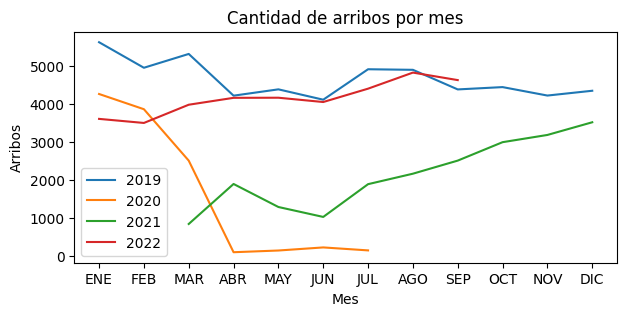

In [22]:
# mensual p/año
años = [2019, 2020, 2021, 2022]
meses = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']

fig, ax = plt.subplots(figsize=(7, 3))

for año in años:
    df[df['año'] == año].groupby(df['mes']).Aero.count().plot()

plt.xlabel('Mes')
plt.ylabel('Arribos')
plt.title('Cantidad de arribos por mes')
plt.legend(años)
plt.xticks(range(1, 13), meses)

plt.show()

El año 2019 muestra una una leve tendencia decreciente en la cantidad de arribos por mes, si bien se nota el efecto estacional de las vacaciones de julio.
En el año 2020 se observa claramente el efecto de la pandemia.
Para el 2021, los vuelos comienzan a recuperarse y siguen haciéndolo a lo largo del 2022.


In [23]:
#@title Creación de nueva columna que contenga el dia que se realizó cada vuelo

dia=[]
for i in df.index:
    d = df['STA'][i].weekday()   #La funcion weekday() devuelve un nuumero del 0 al 6, donde 0 es Lunes y el 6 Domingo
    dia.append(d)
df['Dia_Semana']=dia

<ipython-input-24-7e93f59a3d2b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(column_labels, rotation=45, fontsize=14)
<ipython-input-24-7e93f59a3d2b>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(column_labels, rotation=45,  fontsize=14)
<ipython-input-24-7e93f59a3d2b>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(column_labels, rotation=45,  fontsize=14)
<ipython-input-24-7e93f59a3d2b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(column_labels, rotation=45,  fontsize=14)


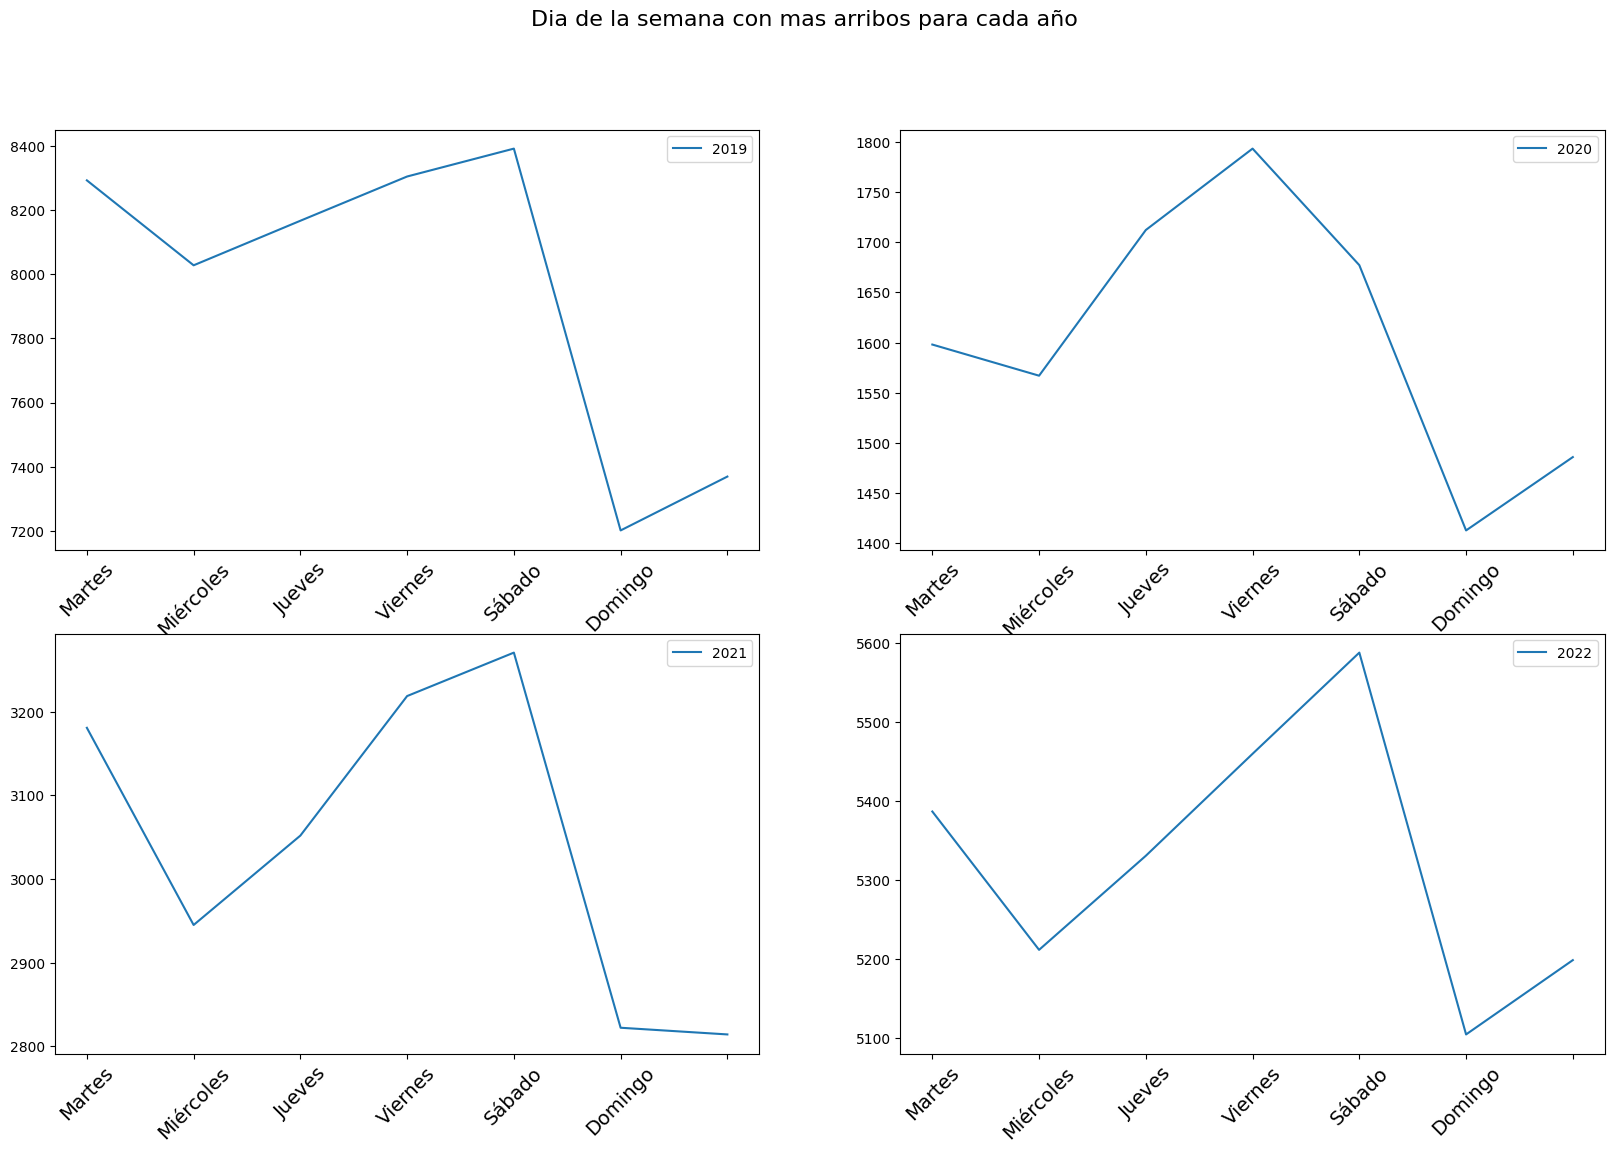

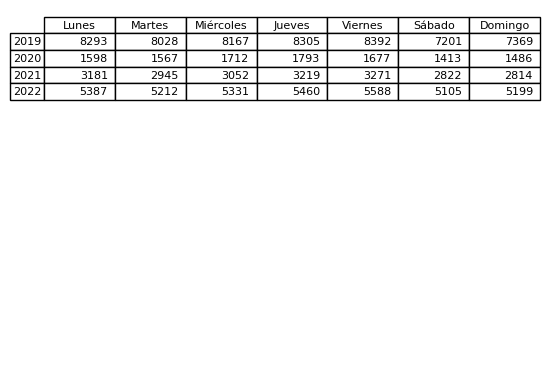

In [24]:
#@title Gráficos para cada año con la cantidad de arribos para cada dia de la semana

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, figsize=(20, 12), sharey=False)
fig.suptitle('Dia de la semana con mas arribos para cada año', fontsize=16)
column_labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

ax1.plot(df[df['año'] == 2019].groupby(df['Dia_Semana']).Aero.count(), label='2019')
ax1.legend()
ax1.set_xticklabels(column_labels, rotation=45, fontsize=14)
ax2.plot(df[df['año'] == 2020].groupby(df['Dia_Semana']).Aero.count(), label='2020')
ax2.legend()
ax2.set_xticklabels(column_labels, rotation=45,  fontsize=14)
ax3.plot(df[df['año'] == 2021].groupby(df['Dia_Semana']).Aero.count(), label='2021')
ax3.legend()
ax3.set_xticklabels(column_labels, rotation=45,  fontsize=14)
ax4.plot(df[df['año'] == 2022].groupby(df['Dia_Semana']).Aero.count(), label='2022')
ax4.legend()
ax4.set_xticklabels(column_labels, rotation=45,  fontsize=14)

plt.show()

fig, ax =plt.subplots(1,1)
data=[df[df['año'] == 2019].groupby(df['Dia_Semana']).Aero.count(),
      df[df['año'] == 2020].groupby(df['Dia_Semana']).Aero.count(),
      df[df['año'] == 2021].groupby(df['Dia_Semana']).Aero.count(),
      df[df['año'] == 2022].groupby(df['Dia_Semana']).Aero.count()
      ]
column_labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
row_labels= ['2019', '2020', '2021', '2022']

ax.axis('tight')
ax.axis('off')
ax.table(cellText=data, colLabels=column_labels, loc='upper center', rowLabels=row_labels)

plt.show()

Para todos los años excepto 2020 (pandemia), el viernes ha sido el día con mayor cantidad de vuelos.

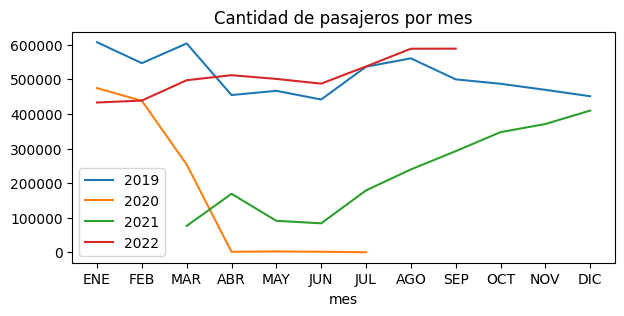

In [25]:
#@title Gráfico cantidad de pasajeros por mes para cada año

fig, ax = plt.subplots(figsize=(7, 3))

for año in años:
    df[df['año'] == año].groupby(df['mes']).Pax.sum().plot()

plt.title('Cantidad de pasajeros por mes')
plt.legend(['2019', '2020', '2021', '2022'])
plt.xticks(range(1, 13), meses)

plt.show()

Se observa que la cantidad de pasajeros tiene una cierta correlación con la cantidad de arribos por mes lo cual es razonable, hay una pequeña diferencia, en el año 2022 se nota un aumento mayor de la cantidad de pasajeros respecto a la de arribos del mismo año.

In [26]:
#@title Creación de columna con la fecha en formato D-M-A


Dma= []
for i in df.index:
    d =  datetime.date(df['STA'][i].year,df['STA'][i].month, df['STA'][i].day)
    Dma.append(d)

df['D_M_A'] = Dma

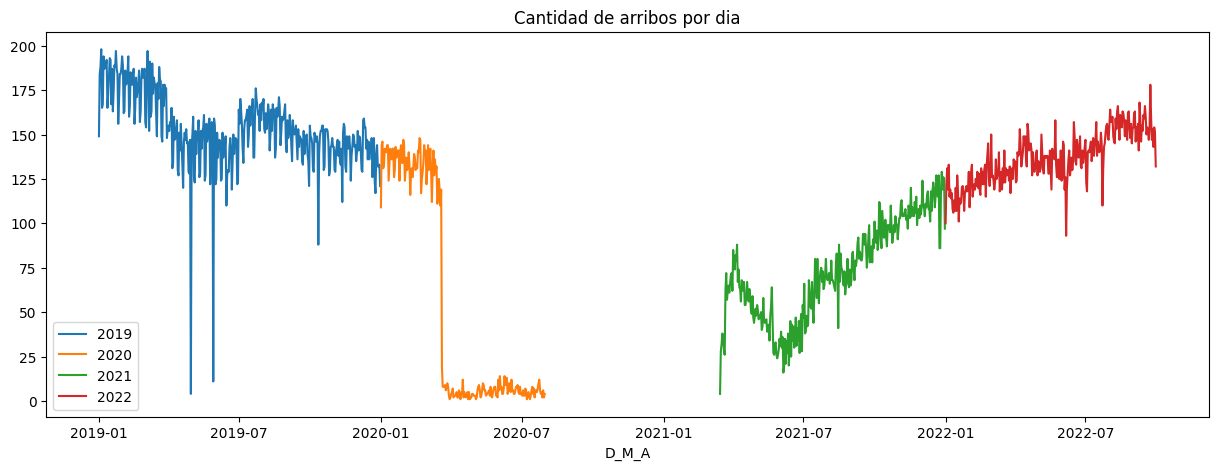

In [27]:
#@title Gráfico cantidad de arribos por día

df[df['año'] == 2019].groupby(df['D_M_A']).Aero.count().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2020].groupby(df['D_M_A']).Aero.count().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2021].groupby(df['D_M_A']).Aero.count().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2022].groupby(df['D_M_A']).Aero.count().plot(kind='line', figsize=(15, 5))

plt.title('Cantidad de arribos por dia')
plt.legend(['2019', '2020', '2021', '2022'])
plt.show()

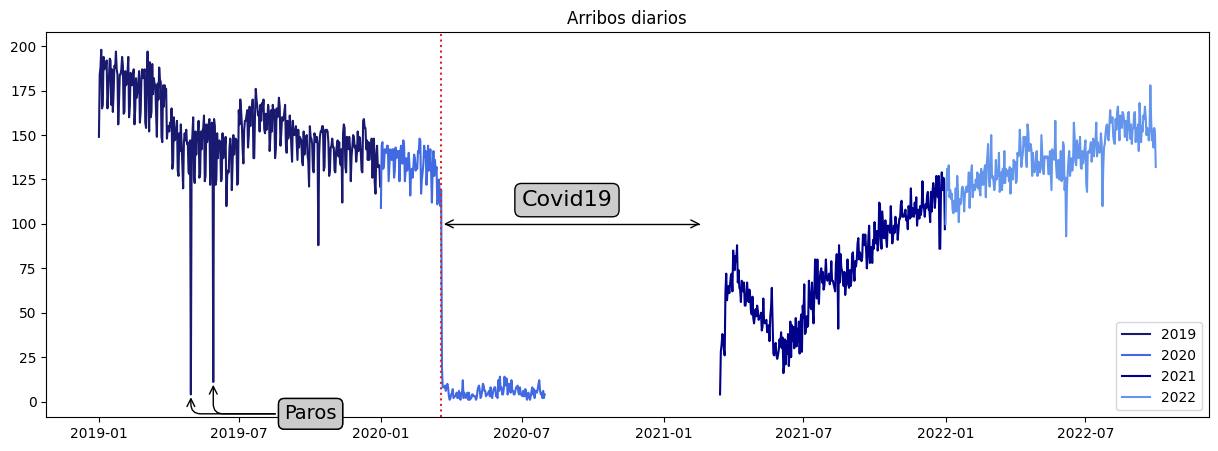

In [28]:
#@title PRESENTACIÓN: Gráfico cantidad de arribos por día

# genero los df por año (se utilizan para los heatmap adelante)
df19 = df[df['año'] == 2019].groupby(df['D_M_A']).Aero.count()
df20 = df[df['año'] == 2020].groupby(df['D_M_A']).Aero.count()
df21 = df[df['año'] == 2021].groupby(df['D_M_A']).Aero.count()
df22 = df[df['año'] == 2022].groupby(df['D_M_A']).Aero.count()

# paros
iparos = np.where(df19 < 25)[0]
paros = df19.index[ iparos ]


# gráfico
df19.plot(kind='line', figsize=(15, 5), color='midnightblue', linestyle='solid' )
df20.plot(kind='line', figsize=(15, 5), color='royalblue', linestyle='solid' )
df21.plot(kind='line', figsize=(15, 5), color='darkblue', linestyle='solid' )
df22.plot(kind='line', figsize=(15, 5), color='cornflowerblue', linestyle='solid' )

covid19 = datetime.date(2020, 3, 19)

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")
#offset = 72  # no se usa
arrowss = dict(
    arrowstyle="<->",
    connectionstyle="angle,angleA=0,angleB=10,rad=0")


# marcas y anotaciones
#plt.scatter(paros[0], df19[iparos[0]] - 10, marker=mpl.markers.CARETUPBASE, color='tab:blue', s=50, label='Peaks')
#plt.scatter(paros[1], df19[iparos[1]] - 10, marker=mpl.markers.CARETUPBASE, color='tab:blue', s=50, label='Peaks')
#plt.scatter( datetime.date(2020, 3, 19), 175, marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Peaks' )
plt.axvline(covid19, color='tab:red', linestyle='dotted')




#plt.text( paros[0] - datetime.timedelta(days=10), df19[iparos[0]] - 10, paros[0], horizontalalignment='right', color='darkblue')
#plt.text( paros[1] + datetime.timedelta(days=10), df19[iparos[1]] - 10, paros[1], horizontalalignment='left', color='darkblue')
#plt.text( datetime.date(2019, 5, 29), -12, 'Paros', size=16, horizontalalignment='left', color='darkblue' )
plt.text( datetime.date(2020, 7, 1), 110, 'Covid19', fontsize=16, horizontalalignment='left', color='black', bbox=bbox)
#plt.annotate('', (datetime.date(2021, 1, 1), 100),
#            xytext=( covid19, 100 ), textcoords='data',
#            arrowprops=dict(facecolor='black', shrink=0.01),
#            fontsize=16,
#            horizontalalignment='right', verticalalignment='top',
#            )
# paros
plt.annotate(
    f'Paros',
    ( paros[0], df19[iparos[0]] ),
    #(datetime.date(2019, 5, 29), 10),
    xytext=(datetime.date(2019, 8, 29), -10), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowprops)
plt.annotate(
    f'Paros',
    ( paros[1], df19[iparos[1]] ),
    xytext=(datetime.date(2019, 8, 29), -10), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowprops)

# covid
plt.annotate(
    f'',
    ( covid19, 100 ),
    xytext=(datetime.date(2021, 3, 1), 100), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowss)


plt.title('Arribos diarios')
plt.legend(['2019', '2020', '2021', '2022'], loc='lower right', )#fontsize='normal')
plt.xlabel('')
plt.show()

#df.loc[np.where( df.groupby(df['D_M_A']).Aero.count() < 25 )].D_M_A
#df19[np.where( df19 < 25 )[0]]
#paros[0] - datetime.date(2019,2,28) #datetime.timedelta(days=5)
#paros[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


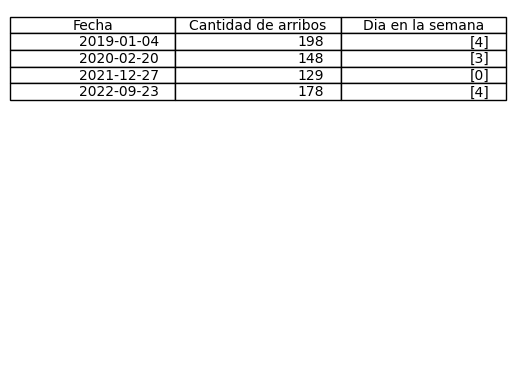

In [29]:
#@title Dia con mayor numero de arribos para cada año

dia_max_arr_2019= df[df['año'] == 2019].groupby(df['D_M_A']).Aero.count().idxmax() , df[df['año'] == 2019].groupby(df['D_M_A']).Aero.count().max(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2019].groupby(df['D_M_A']).Aero.count().idxmax()]].unique()
dia_max_arr_2020= df[df['año'] == 2020].groupby(df['D_M_A']).Aero.count().idxmax() , df[df['año'] == 2020].groupby(df['D_M_A']).Aero.count().max(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2020].groupby(df['D_M_A']).Aero.count().idxmax()]].unique()
dia_max_arr_2021= df[df['año'] == 2021].groupby(df['D_M_A']).Aero.count().idxmax() , df[df['año'] == 2021].groupby(df['D_M_A']).Aero.count().max(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2021].groupby(df['D_M_A']).Aero.count().idxmax()]].unique()
dia_max_arr_2022= df[df['año'] == 2022].groupby(df['D_M_A']).Aero.count().idxmax() , df[df['año'] == 2022].groupby(df['D_M_A']).Aero.count().max(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2022].groupby(df['D_M_A']).Aero.count().idxmax()]].unique()

fig, ax =plt.subplots(1,1)
data=[dia_max_arr_2019, dia_max_arr_2020, dia_max_arr_2021, dia_max_arr_2022]
column_labels=['Fecha', 'Cantidad de arribos', 'Dia en la semana']

ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels, loc='upper center')

plt.show()

Para el año 2019 el dia con mayor número de arribos es el primer viernes del mes de enero, lo que se corresponde con los análisis anteriores. En este año se ven dos picos mínimos que corresponden a dias de paros gremiales del sector aeronáutico ([fuentes](https://www.lanacion.com.ar/tema/el-conflicto-en-aerolineas-tid47393/)).

Para el año 2020, se puede ver que el día con mayor número de arribos fue el dia jueves antes del fin de semana largo de carnavales en el mes de febrero.

Para los años 2021 y 2022 se ve que el crecimiento en el número de arribos es gradual, debido a la post pandemia y a la normalización gradual de las actividades cotidianas.

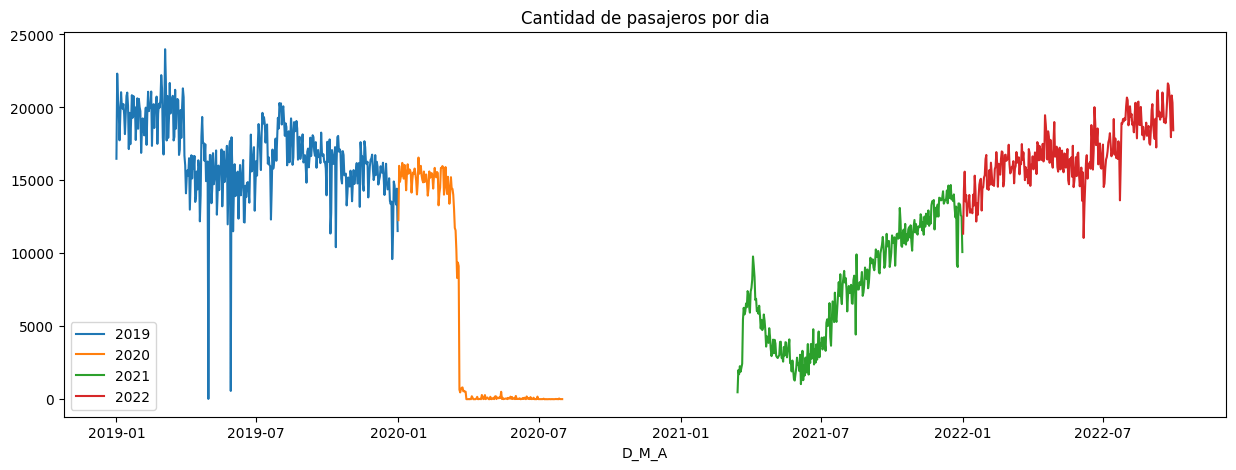

In [30]:
#@title Gráfico de cantidad de pasajeros por día

df[df['año'] == 2019].groupby(df['D_M_A']).Pax.sum().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2020].groupby(df['D_M_A']).Pax.sum().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2021].groupby(df['D_M_A']).Pax.sum().plot(kind='line', figsize=(15, 5))
df[df['año'] == 2022].groupby(df['D_M_A']).Pax.sum().plot(kind='line', figsize=(15, 5))

plt.title('Cantidad de pasajeros por dia')
plt.legend(['2019', '2020', '2021', '2022'])
plt.show()

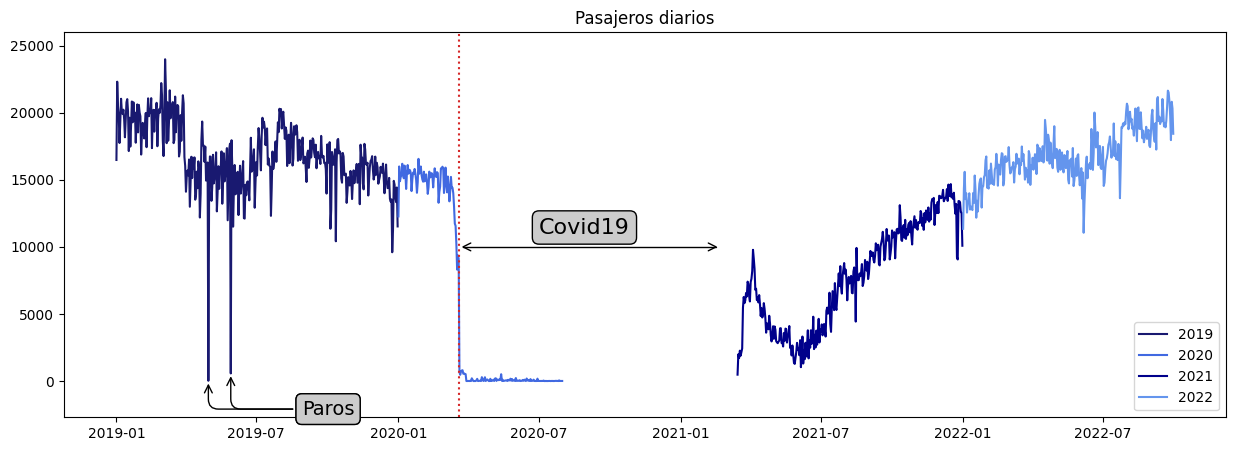

In [31]:
#@title PRESENTACIÓN: Gráfico cantidad de pasajeros por día

# genero los df por año
df19p = df[df['año'] == 2019].groupby(df['D_M_A']).Pax.sum()
df20p = df[df['año'] == 2020].groupby(df['D_M_A']).Pax.sum()
df21p = df[df['año'] == 2021].groupby(df['D_M_A']).Pax.sum()
df22p = df[df['año'] == 2022].groupby(df['D_M_A']).Pax.sum()

# paros
iparos = np.where(df19 < 25)[0]
paros = df19p.index[ iparos ]


# gráfico
df19p.plot(kind='line', figsize=(15, 5), color='midnightblue', linestyle='solid' )
df20p.plot(kind='line', figsize=(15, 5), color='royalblue', linestyle='solid' )
df21p.plot(kind='line', figsize=(15, 5), color='darkblue', linestyle='solid' )
df22p.plot(kind='line', figsize=(15, 5), color='cornflowerblue', linestyle='solid' )

covid19 = datetime.date(2020, 3, 19)

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")
#offset = 72  # no se usa
arrowss = dict(
    arrowstyle="<->",
    connectionstyle="angle,angleA=0,angleB=10,rad=0")


# marcas y anotaciones
#plt.scatter(paros[0], df19[iparos[0]] - 10, marker=mpl.markers.CARETUPBASE, color='tab:blue', s=50, label='Peaks')
#plt.scatter(paros[1], df19[iparos[1]] - 10, marker=mpl.markers.CARETUPBASE, color='tab:blue', s=50, label='Peaks')
#plt.scatter( datetime.date(2020, 3, 19), 175, marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Peaks' )
plt.axvline(covid19, color='tab:red', linestyle='dotted')




#plt.text( paros[0] - datetime.timedelta(days=10), df19[iparos[0]] - 10, paros[0], horizontalalignment='right', color='darkblue')
#plt.text( paros[1] + datetime.timedelta(days=10), df19[iparos[1]] - 10, paros[1], horizontalalignment='left', color='darkblue')
#plt.text( datetime.date(2019, 5, 29), -12, 'Paros', size=16, horizontalalignment='left', color='darkblue' )
plt.text( datetime.date(2020, 7, 1), 11000, 'Covid19', fontsize=16, horizontalalignment='left', color='black', bbox=bbox)
#plt.annotate('', (datetime.date(2021, 1, 1), 100),
#            xytext=( covid19, 100 ), textcoords='data',
#            arrowprops=dict(facecolor='black', shrink=0.01),
#            fontsize=16,
#            horizontalalignment='right', verticalalignment='top',
#            )
# paros
lower = -2500
plt.annotate(
    f'Paros',
    ( paros[0], df19p[iparos[0]] ),
    #(datetime.date(2019, 5, 29), 10),
    xytext=(datetime.date(2019, 8, 29), lower), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowprops)
plt.annotate(
    f'Paros',
    ( paros[1], df19p[iparos[1]] ),
    xytext=(datetime.date(2019, 8, 29), lower), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowprops)

# covid
plt.annotate(
    f'',
    ( covid19, 10000 ),
    xytext=(datetime.date(2021, 3, 1), 10000), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowss)


plt.title('Pasajeros diarios')
plt.legend(['2019', '2020', '2021', '2022'], loc='lower right', )#fontsize='normal')
plt.xlabel('')
plt.ylim([-2700, 26000])
plt.show()

#df.loc[np.where( df.groupby(df['D_M_A']).Aero.count() < 25 )].D_M_A
#df19[np.where( df19 < 25 )[0]]
#paros[0] - datetime.date(2019,2,28) #datetime.timedelta(days=5)
#paros[0]

<Figure size 1280x800 with 0 Axes>

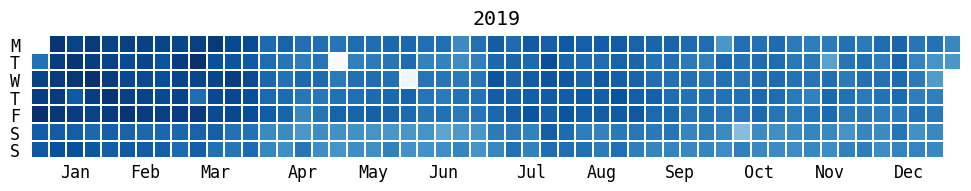

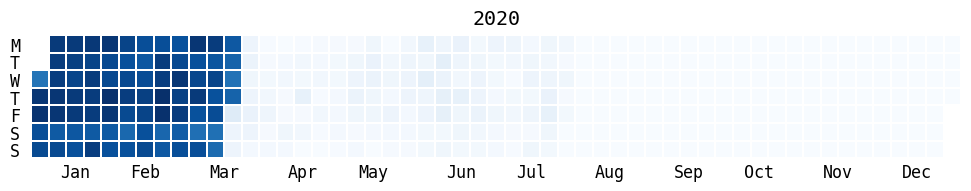

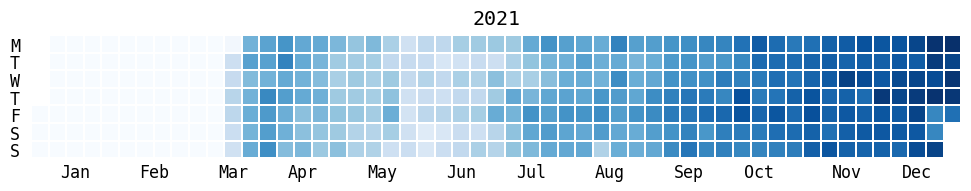

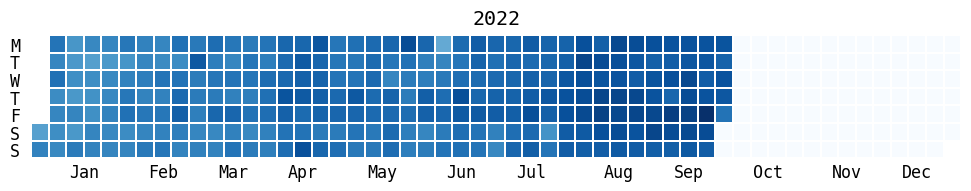

In [32]:
#@title PRESENTACIÓN: Gráfico calmap para arribos por día en el año

dfhm = df[['ATA', 'Pax', 'año', 'mes', 'hora' ]].copy()
#dfhm19 = dfhm[dfhm['año'] ==  2019]
#dfhm20 = dfhm[dfhm['año'] ==  2020]
#dfhm21 = dfhm[dfhm['año'] ==  2021]
#dfhm22 = dfhm[dfhm['año'] ==  2022]
#dfhm = df.copy()

meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
diass = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']

#print(dfhm.info())
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16,10), dpi= 80)
plt.figure(figsize=(16,10), dpi= 80)

#dfhm.set_index('ATA', inplace=True)
#calmap.calendarplot(
#    dfhm['mes'],
#    #how=u'sum', # u'sum' default
#    yearlabels=True,
#    cmap='Blues',
#    ##fillcolor='grey',
#    linewidth=0.01,
#    yearascending=False,
#    fig_kws=dict(figsize=(15, 9)),
#    monthlabels=meses,
#    monthticks=True,
#    daylabels=diass,
#    )
#
#plt.show()
#dfhm

# src: https://github.com/e-hulten/july

#july.heatmap(dfhm19.ATA, dfhm19.Pax, cmap='Blues')
#plt.figure(figsize=(16,10), dpi= 80)
#july.heatmap(dfhm20.ATA, dfhm20.Pax, cmap='Blues')
#plt.figure(figsize=(16,10), dpi= 80)
#july.heatmap(dfhm21.ATA, dfhm21.Pax, cmap='Blues')
#plt.figure(figsize=(16,10), dpi= 80)
#july.heatmap(dfhm22.ATA, dfhm22.Pax, cmap='Blues')
#df[66980:67030 ] # Faltan datos desde 01/08/20 al 14/03/21

# se agregan los días faltantes para completar heatmap de july
# generación del rando de fechas
f19 = july.utils.date_range("2019-01-01", "2019-01-01")
f20 = july.utils.date_range("2020-08-01", "2020-12-31")
f21 = july.utils.date_range("2021-01-01", "2021-03-14")
f22 = july.utils.date_range("2022-10-01", "2022-12-31")
# generación de los 0's para la cantidad en Aero
datos19 = df19[0]
datos20 = np.zeros(len(f20))#; year20 = datos20; year20 = 2020
datos21 = np.zeros(len(f21))
datos22 = np.zeros(len(f22))

def df_completo(fechas, datos, dfn):
  """
  Función para completar los datos y fechas del data set en heatmaps de july
  In:
    fechas: rango de fechas a completar
    datos: vector con valores a completar, con igual tamaño que fechas
    dfn: serie de pandas
  Out:
    dfu: DataFrame actualizado y completo
    y gráfico con july
    src: https://github.com/e-hulten/july
  """
  # generamos el df con fechas y datos faltantes
  dftemp = pd.DataFrame.from_dict({
      'ATA': fechas,
      'Aero': datos,
      })
  dftemp.set_index('ATA', inplace=True)
  dftrans = pd.DataFrame(dfn)
  dfu = pd.concat( [dftrans, dftemp], ignore_index=False)
  #july.heatmap(dfu.index, np.log10(dfu.Aero+1.), cmap='Blues', dpi=80)
  july.heatmap(dfu.index, dfu.Aero, cmap='Blues', dpi=80)
  return dfu

dfhm19 = df_completo( f19, datos19, df19)
dfhm20 = df_completo( f20, datos20, df20)
dfhm21 = df_completo( f21, datos21, df21)
dfhm22 = df_completo( f22, datos22, df22)

dffhm = pd.concat([dfhm19, dfhm20, dfhm21, dfhm22])

#dfhm200 = pd.DataFrame.from_dict({
#    'ATA': f20,
#    'Aero': datos20,
#    #'año': year20,
#    #'mes': datos20,
#    #'hora': datos20
#    })
#dfhm200.set_index('ATA', inplace=True)
#dfhm20d = pd.DataFrame(df20)
#dfhm20 = pd.concat( [dfhm20d, dfhm200], ignore_index=False)
##dfhm20['año'] = 2020
#display((dffhm.index.to))
#display(np.unique(dffhm.index.year))
#calmap.calendarplot(
#    dfhm.Pax,
#    #how=u'sum', # u'sum' default
#    yearlabels=True,
#    cmap='Blues',
#    ##fillcolor='grey',
#    linewidth=0.0,
#    yearascending=False,
#    fig_kws=dict(figsize=(15, 9)),
#    monthlabels=meses,
#    monthticks=True,
#    daylabels=diass,
#    )
#plt.show()



In [33]:
#@title PRESENTACIÓN: Heatmap de la los arribos por mes/año

fig = px.density_heatmap(dfhm, x='mes', y='año',#z= 'hora',
                        #marginal_x= 'histogram',
                        #marginal_y='histogram'
                        #title='Arribos mensuales',
                        color_continuous_scale="blues",
                        #text_auto=True,  # muestra los valores
                        category_orders={
                            '2019': 2019,
                            '2020': 2020,
                            '2021': 2021,
                            '2022': 2022,
                            }
                        )
#fig.update_xaxes(labelalias=dict(0=="Lunes", 1=="Martes", 2=="Miércoles", 3=="Jueves", 4="Viernes", 5="Sábado", 6="Domingo" ))
fig.update_yaxes(ticklabelstep=2, tickfont=dict(size=20))
fig.update_xaxes(
    ticktext=["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"],
    tickvals=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"],
    tickfont=dict(size=20)
)
fig.update_traces(showscale=False)
fig.layout['coloraxis']['colorbar']['title'] = 'Arribos'
fig.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



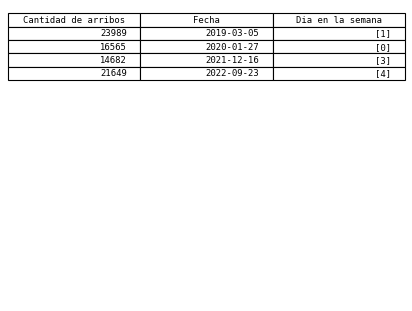

In [34]:
#@title Dia con mayor numero de pasajeros para cada año

dia_max_pax_2019 = df[df['año'] == 2019].groupby(df['D_M_A']).Pax.sum().max(), df[df['año'] == 2019].groupby(df['D_M_A']).Pax.sum().idxmax(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2019].groupby(df['D_M_A']).Pax.sum().idxmax()]].unique()
dia_max_pax_2020 = df[df['año'] == 2020].groupby(df['D_M_A']).Pax.sum().max(), df[df['año'] == 2020].groupby(df['D_M_A']).Pax.sum().idxmax(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2020].groupby(df['D_M_A']).Pax.sum().idxmax()]].unique()
dia_max_pax_2021 = df[df['año'] == 2021].groupby(df['D_M_A']).Pax.sum().max(), df[df['año'] == 2021].groupby(df['D_M_A']).Pax.sum().idxmax(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2021].groupby(df['D_M_A']).Pax.sum().idxmax()]].unique()
dia_max_pax_2022 = df[df['año'] == 2022].groupby(df['D_M_A']).Pax.sum().max(), df[df['año'] == 2022].groupby(df['D_M_A']).Pax.sum().idxmax(), df['Dia_Semana'][df.index[df['D_M_A']== df[df['año'] == 2022].groupby(df['D_M_A']).Pax.sum().idxmax()]].unique()

fig, ax =plt.subplots(1,1)
data=[dia_max_pax_2019, dia_max_pax_2020, dia_max_pax_2021, dia_max_pax_2022]
column_labels=['Cantidad de arribos', 'Fecha', 'Dia en la semana']

ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,colLabels=column_labels, loc='upper center')

plt.show()

Para el año 2019 el día de mayor número de pasajeros es el martes 5 de marzo, el cual fue el último día del fin de semana largo de carnavales de ese año.

Para el año 2020 el día con mayor número de pasajeros es un lunes 27 de enero, el cual no es un día especial.

Para los años 2021 y 2022 se ve que el crecimiento en el número de arribos es gradual, debido a la post pandemia y a la normalización gradual de las actividades cotidianas.

### Cabecera que más se utilizó

In [35]:
#cabecera con más frecuencia
print('CABECERA USO (%)')
df.Cabecera.value_counts(normalize=True).round(1)

CABECERA USO (%)


13.00   0.70
31.00   0.30
Name: Cabecera, dtype: float64

La cabecera 13 es la que más se utilizó (70%).

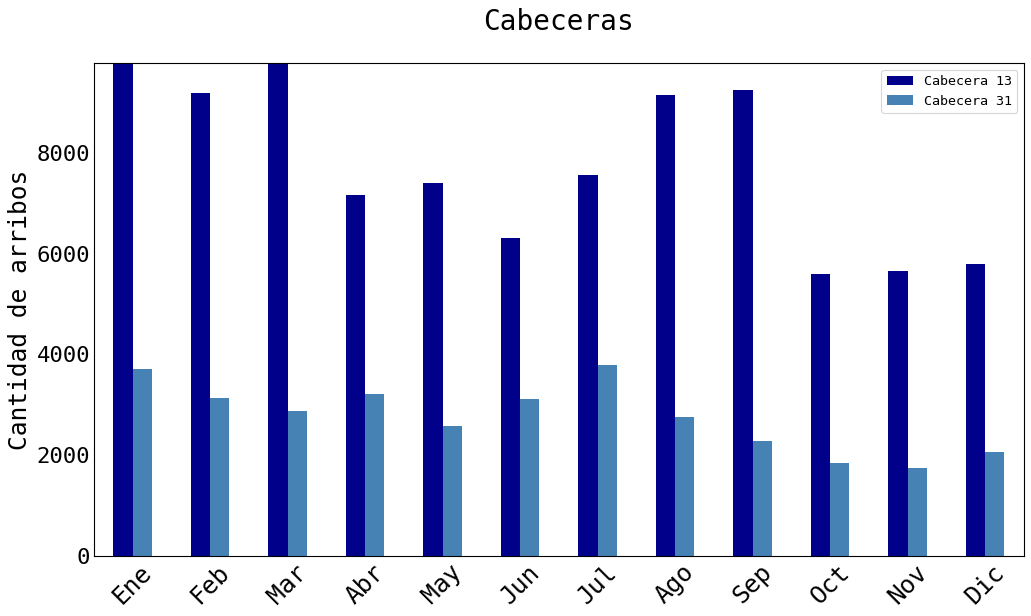

In [36]:
cabeceras = ['Cabecera 13', 'Cabecera 31']
colores = ['darkblue', 'steelblue']  # Colores para cada valor de cabecera

ax = df.groupby(df['mes']).Cabecera.value_counts().unstack().plot(kind='bar', figsize=(15, 8), color= colores)

plt.ylabel('Cantidad de arribos', fontsize=22)
#plt.title('Arribos de cada cabecera por mes', fontsize=25)
plt.title('Cabeceras', fontsize=25)
ax.set_xticklabels(meses, rotation=45, fontsize=22)
ax.tick_params(axis='y', labelsize=20)
ax.legend(cabeceras)
plt.xlabel('')
plt.show()

Para todos los meses la cabecera que más se utilizó es la 13.

##2. Traduciendo los retrasos



### Cálculo de las distancias entre los aeropuertos y Aeroparque

Primero agregamos una nueva característica que contempla la distancia a AEP.

In [37]:
#def plot_examples(colormaps):
#    """
#    Helper function to plot data with associated colormap.
#    """
#    np.random.seed(19680801)
#    data = np.random.randn(30, 30)
#    n = len(colormaps)
#    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
#                            constrained_layout=True, squeeze=False)
#    for [ax, cmap] in zip(axs.flat, colormaps):
#        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
#        fig.colorbar(psm, ax=ax)
#    plt.show()
#
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#colors = ["lightsteelblue", "cornflowerblue", "royalblue", "blue", "mediumblue", "darkblue", "navy", "midnightblue"]
#cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
#nodes = [0.0, 0.4, 0.8, 1.0]
#cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
#
#my_cmap = ListedColormap(colors, name="my_cmap")
#my_cmap_r = my_cmap.reversed()
#
#plot_examples([my_cmap, my_cmap_r])

In [38]:
#@title cálculo de distancias geodésica y ubicación en el planisferio

def distancia_geodesica( alat, alon):
  """
  Dados dos puntos en la superficie de la Tierra, se calcula la distancia
  geodésica entre ellos.

  Se introducen latitud (alat) y longitud (alon) del punto deseado y se calcula
  la distancia a Aeroparque.

  Las coordenadas deben ingresar y se las arma como tupla (tuples): (lat, lon)

  Se almacena el nombre para verificar si ya fue calculado para asignar la
  distancia al aeropuerto.

  Devuelve la distancia geodésica al punto ingresado expresada en kilómetros.
  """
  # ubicación geográfica del Aeroparque Jorge Newbery
  # src: https://nominatim.openstreetmap.org/ui/details.html?osmtype=R&osmid=4524923&class=aeroway
  AEP = (-34.5594401,-58.41438230065185)
  punto = (alat, alon)
  return geodesic(AEP, punto).km


def distancia(ddf):
  """
  Se introduce un DataFrame con las coordenadas, el índice corresponde al
  nombre del aeropuerto.

  Devuelve la distancia geodésica al aeropuerto desde Aeroparque JN.
  """
  adist = []
  for i, ubi in enumerate(ddf.index):
    adist.append( distancia_geodesica( ddf['lat'][i], ddf['lon'][i]) )
    #print(i, ddf.index[i], adist[i])
  return ddf.index, adist


# genero nuevo df temporal con Origen, lat y lon, agrupados por Origen
coord = df.groupby(['Origen'])['lat', 'lon'].mean() # no interesa la operación que se le realice, ya que poseen el mismo valor. Con std vemos que es el mismo valor siempre

# necesario para agregar al db porque se complica la identificación con el índice (que corresponde con el aeropuerto)
ubi = df.Origen.unique() #.tolist()
ubi.sort()
coord['Origen'] = ubi

# Se Calcula la distancia geodésica en km al aeropuerto
[_, distancia_AEP] = distancia(coord)
coord['dist'] = distancia_AEP


# gráfico
fig = scatter1 = px.scatter_geo(coord, lon='lon', lat='lat',
                                color=coord['dist'],
                                color_continuous_scale='jet',
                                opacity=0.9,
                                labels={'color': 'distancia (km)'},
                                #size='dist'
                                )
fig.update_geos(fitbounds="locations")  # Adjust the map bounds to fit the data
fig.update_layout(
    title = 'Ubicación geográfica de los aeropuertos con destino a AEP. <br> Los colores representan la distancia a Aeroparque en km'
)
fig.show()

# Añadido de columna con distancias en km
dist_col = []
for i in range(len(df)): # lento, compara y recorre todo el dataset
  ia = np.where( coord.Origen == df.Origen[i] )[0][0]
  dist_col.append(coord.dist[ia])

df['dist'] = dist_col

<ipython-input-38-1ff1825a0fb7>:40: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



### Definimos los posibles targets:

- TD1: Time-Delta 1 - diferencia entre el horario efectivo de arribo y el horario programado. Corresponde al retraso total generado tanto por el retraso en la salida del vuelo como en la llegada

- TD2: Time-Delta 2 - diferencia entre el horario estimado y el horario programado. Este retraso estaría vinculada con el retraso en origen de la salida, es decir el retraso del vuelo respecto a la hora programada.

- TD3: Time-Delta 3 - diferencia entre el horario efectivo de arribo y el horario estimado. Se interpreta como retraso por el vuelo, una vez que ya salio de su origen.

**Todos los valores están expresados en `minutos`**

In [39]:
# Se agregan columnas que tienen las diferencias entre STA, ETA y ATA,
# el resultado queda expresado en minutos

# para expresar los resultados como número real y en días
norm1D =  np.timedelta64(1,'m') # con D en días, h en horas

# retraso total = retraso en origen + retraso en vuelo
df['TD1'] = ( df['ATA'] - df['STA'] ) / norm1D
# retraso en origen, es decir retraso en la salida del vuelo respecto a la programada
df['TD2'] = ( df['ETA'] - df['STA'] ) / norm1D
# retraso en vuelo, relacionada directamente con el vuelo
df['TD3'] = ( df['ATA'] - df['ETA'] ) / norm1D

print(f'TD1: \n {df.TD1.describe()} \n\n',
      f'TD2: \n {df.TD2.describe()} \n\n',
      f'TD3: \n {df.TD3.describe()}'
      )

TD1: 
 count   125587.00
mean        -1.29
std         41.11
min      -1440.00
25%        -17.00
50%         -8.00
75%          0.00
max       1885.00
Name: TD1, dtype: float64 

 TD2: 
 count   125587.00
mean        -1.18
std         81.74
min      -1530.00
25%        -15.00
50%         -6.00
75%          0.00
max       1885.00
Name: TD2, dtype: float64 

 TD3: 
 count   125587.00
mean        -0.11
std         70.52
min      -1439.00
25%         -2.00
50%          0.00
75%          2.00
max       1439.00
Name: TD3, dtype: float64


Para TD1, el 50% central de los datos se ubica entre 17 minutos de adelanto (valores negativos de retraso) y 0. La mediana es 8 minutos de adelanto.

#### Análisis de los rangos intercuartiles como criterio para elección de `retraso`:

In [40]:
#@title Análisis de los estadísticos como criterio para elección de "retraso"

cols = ['TD1', 'TD2', 'TD3']

tabla_valores = []
for i, tdi in enumerate(cols):
  IQR = df[tdi].quantile(.75)-df[tdi].quantile(.25)
  Qup = df[tdi].quantile(.75) + IQR * 1.5
  Qdown = df[tdi].quantile(.25) - IQR * 1.5
  Nup = df[tdi].mean() - 3 * df[tdi].std()
  Ndown = df[tdi].mean() + 3 * df[tdi].std()
  tabla_valores.append([tdi, df[tdi].median(), IQR, Qup, Qdown, df[tdi].mean(), df[tdi].std(), Nup, Ndown])

## Encabezados de la tabla
encabezados = ['Mediana', 'IQR', 'Q3+1.5×IQR', 'Q1-1.5×IQR', 'Media', 'Desviación estándar (s)', 'Media+3×s', 'Media-3×s']

# Imprimir la tabla formateada
print("Estadísticos expresados en minutos para las 3 categorías de retraso")
print(tabulate(tabla_valores, headers=encabezados, tablefmt="fancy_grid"))

# Definimos nuestra tolerancia para considerar restraso o no
Retraso = {
    'TD1': tabla_valores[0][3],
    'TD2': tabla_valores[1][3],
    'TD3': tabla_valores[2][3]
    }

print(f'\n Retraso según el indicador que se considere: {Retraso} expresadas en minutos.')

Estadísticos expresados en minutos para las 3 categorías de retraso
╒═════╤═══════════╤═══════╤══════════════╤══════════════╤═══════════╤═══════════════════════════╤═════════════╤═════════════╕
│     │   Mediana │   IQR │   Q3+1.5×IQR │   Q1-1.5×IQR │     Media │   Desviación estándar (s) │   Media+3×s │   Media-3×s │
╞═════╪═══════════╪═══════╪══════════════╪══════════════╪═══════════╪═══════════════════════════╪═════════════╪═════════════╡
│ TD1 │        -8 │    17 │         25.5 │        -42.5 │ -1.28779  │                   41.1113 │    -124.622 │     122.046 │
├─────┼───────────┼───────┼──────────────┼──────────────┼───────────┼───────────────────────────┼─────────────┼─────────────┤
│ TD2 │        -6 │    15 │         22.5 │        -37.5 │ -1.1763   │                   81.744  │    -246.408 │     244.056 │
├─────┼───────────┼───────┼──────────────┼──────────────┼───────────┼───────────────────────────┼─────────────┼─────────────┤
│ TD3 │         0 │     4 │          8   │        

Queda definido el límite para vuelos _retrasados_ en 25.5 min para TD1, 22.5 min para TD2 y 8 min para TD3.

/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:2870: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:2873: RuntimeWarning:

invalid value encountered in double_scalars



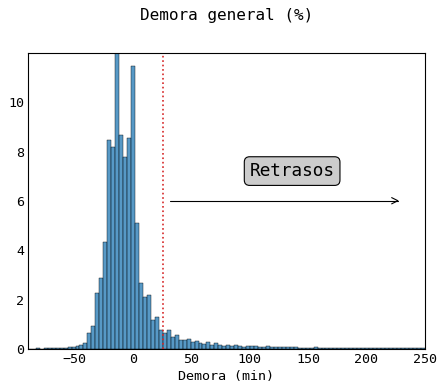

In [41]:
#@title PRESENTACIÓN: Gráficos de los distintos retrasos

df2plt = df[['TD1', 'TD2', 'TD3', 'dist', 'lat', 'lon', 'Pax']].copy()
bins = 100

# TD1
x = 'TD1'
#sns.histplot(data=df2plt, bins=bins, stat='density', binrange=(-100,300), x=x,)
sns.histplot(data=df2plt, bins=bins, stat='percent', x=x, binrange=(-90,250),)
#plt.title(f"Distribución de densidad para el retraso {x}")
plt.title(f"Demora general (%)")
#plt.xlabel(f'Retraso {x}  (min)')
plt.xlabel('Demora (min)')
plt.ylabel('')

plt.axvline(25.5, color='tab:red', linestyle='dotted')

plt.annotate(
    f'',
    ( 230, 6 ),
    xytext=(25.5, 6), textcoords='data',
    size=14,
    bbox=bbox, arrowprops=arrowprops)
plt.text( 100, 7, 'Retrasos', fontsize=16, horizontalalignment='left', color='black', bbox=bbox)

plt.show()

Se observa que la distribución no se corresponde con una distribución normal, sino más bien a una distribución sesgada. Además presenta una sobredensidad en 0 debida a que es el valor más esperado por la variable utilizada.

Text(0.5, 0, 'Retraso TD2 (min)')

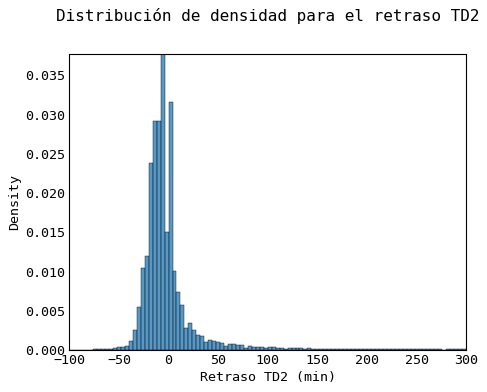

In [42]:
# TD2
x = 'TD2'
sns.histplot(data=df2plt, bins=bins, stat='density', binrange=(-100,300), x=x)
plt.title(f"Distribución de densidad para el retraso {x}")
plt.xlabel(f'Retraso {x} (min)')

Para la distribución de TD2 se observa un comportamiento similar a TD1.

Text(0, 0.5, '')

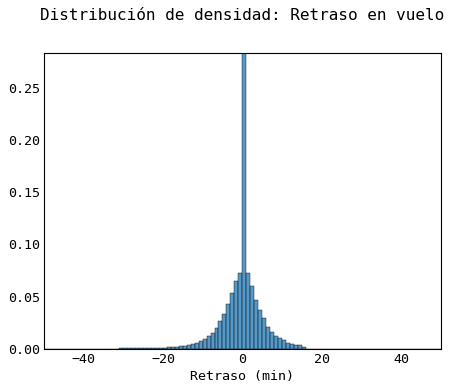

In [43]:
# TD3
x = 'TD3'
sns.histplot(df2plt[x], bins=bins, stat='density', binrange=(-50,50))
plt.title(f"Distribución de densidad para el retraso {x}")
plt.xlabel(f'Retraso {x} (min)')
plt.title(f"Distribución de densidad: Retraso en vuelo")
plt.xlabel(f'Retraso (min)')
plt.ylabel('')

En cambio, para la distribución de TD3 corresponde a una distribución simétrica respecto al origen.

Text(0.5, 1.0, 'Superposión de distribuciones de los retraso TD1 y TD2')

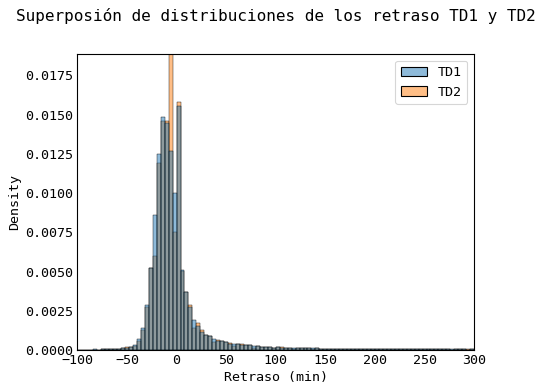

In [44]:
# TD1 y TD2
x1 = 'TD1'
x2 = 'TD2'
dftemp = df2plt[[x1, x2]]
sns.histplot(data=dftemp, bins=bins, stat='density', binrange=(-100,300) )
plt.xlabel('Retraso (min)')
plt.title(f'Superposión de distribuciones de los retraso {x1} y {x2}')


Distribuciones TD1 y TD2 superpuestas para comparación. Se observa que ambas son muy similares y ambas poseen la sobredensidad en 0.

<ipython-input-45-837a2462bad5>:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-45-837a2462bad5>:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




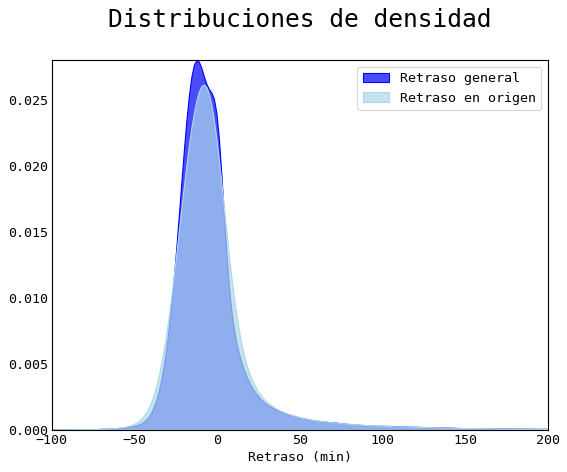

In [45]:
#@title PRESENTACIÓN: Distribuciondes de densidad de los retrasos

plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot( df2plt.TD1, shade=True, color='blue', label="Retraso general", alpha=.7, clip=(-100, 200))
sns.kdeplot( df2plt.TD2, shade=True, color='lightblue', label="Retraso en origen", alpha=.7, clip=(-100, 200))
    #df.loc[df['cyl'] == 4, "cty"], shade=True, color="g", label="Cyl=4", alpha=.7)
#sns.kdeplot(df.loc[df['cyl'] == 5, "cty"], shade=True, color="deeppink", label="Cyl=5", alpha=.7)
#sns.kdeplot(df.loc[df['cyl'] == 6, "cty"], shade=True, color="dodgerblue", label="Cyl=6", alpha=.7)
#sns.kdeplot(df.loc[df['cyl'] == 8, "cty"], shade=True, color="orange", label="Cyl=8", alpha=.7)

#sns.histplot(df2plt.TD2,
#             color='lightblue',
#             kde=True,
#             stat='density',
#             binrange=(-100, 300),
#             bins=bins,
#             label='Retraso en origen',
#             ).set(xlim=(-100,300))
#
#sns.histplot( df2plt.TD1, #df2plt.TD2),
#             color='blue',
#             kde=True,
#             stat='density',
#             binrange=(-100, 300),
#             bins=bins,
#             label='Retraso general',
#             ).set(xlim=(-100,300))
#


# Decoration
plt.title('Distribuciones de densidad', fontsize=22)
plt.ylabel('')
plt.xlabel('Retraso (min)')
plt.legend()
plt.show()

Text(0.5, 0, 'Retraso general')

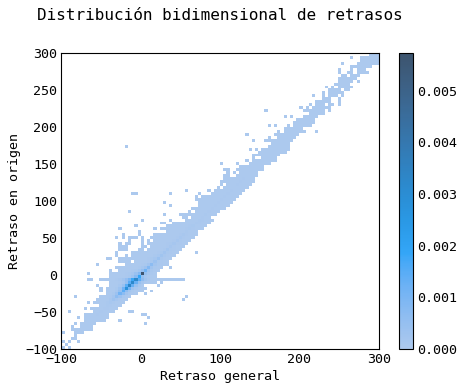

In [46]:
# TD1 y TD2
x = 'TD1'
y = 'TD2'
sns.histplot(data=df2plt, bins=bins, stat='density', binrange=(-100,300), x=x, y=y, cbar=True )
plt.title(f'Distribución bidimensional de los retraso {x} y {y}')
plt.title(f'Distribución bidimensional de retrasos')
plt.ylabel('Retraso en origen')
plt.xlabel('Retraso general')

Distribución bidimensional entre TD1 y TD2. Se observa una región con el máximo local previo al origen y el pico máximo en el origen. También se observa la correlación existente entre ambos retrasos.

Text(0.5, 1.0, 'Distribución bidimensional de los retraso TD1 y TD3')

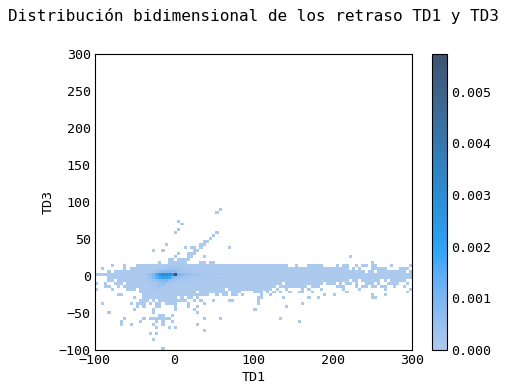

In [47]:
# TD1 y TD3
x = 'TD1'
y = 'TD3'
sns.histplot(data=df2plt, bins=bins, stat='density', binrange=(-100,300), x=x, y=y, cbar=True )
plt.title(f'Distribución bidimensional de los retraso {x} y {y}')

Distribución bidimensional entre TD1 y TD3. Se observan las mismas características que entre TD1 y TD2 con sus dos máximos, una región con máximo local previo al origen y el máximo absoluto en el origen. No presentan correlación observable las variables.

Text(0.5, 1.0, 'Distribución bidimensional de los retraso TD2 y TD3')

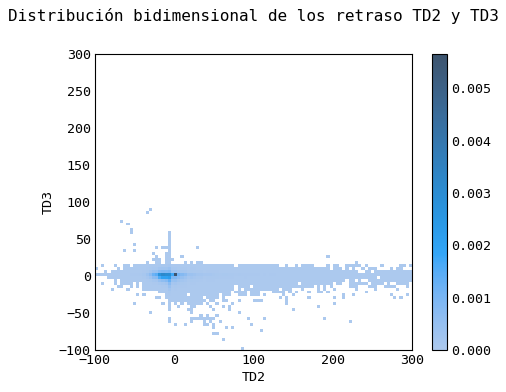

In [48]:
# TD2 y TD3
x = 'TD2'
y = 'TD3'
sns.histplot(data=df2plt, bins=bins, stat='density', binrange=(-100,300), x=x, y=y, cbar=True )
plt.title(f'Distribución bidimensional de los retraso {x} y {y}')

Por última la distribución bidimensional entre TD2 y TD3. Se observa un comportamiento equivalente al gráfico de distribución entre TD1 y TD3.

Text(0.5, 1.0, 'Gráfico de dispersión entre la distancia y el Retraso TD1')

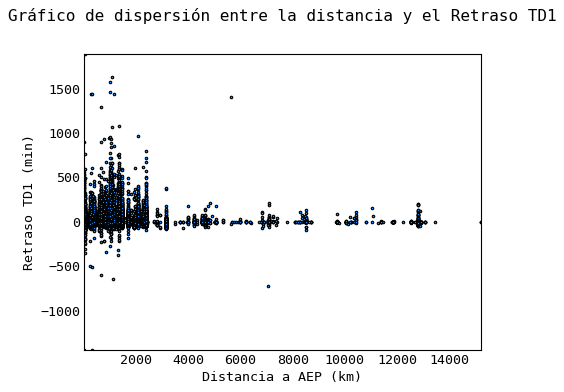

In [49]:
# Gráfico de dispersión del retraso con la distancia
x = 'dist'
y = 'TD1'
plt.scatter(df[x], df[y], s=5, facecolor="dodgerblue", edgecolor="k")
plt.xlabel("Distancia a AEP (km)")
plt.ylabel(f"Retraso {y} (min)")
plt.title(f"Gráfico de dispersión entre la distancia y el Retraso {y}")

Gráfico de dispersión entre la distacia a Aeroparque y el retraso TD1. No se observan una correlación evidente entre ambas variables, solamente que a menor distancia hay mayor retraso.

Text(0, 0.5, '')

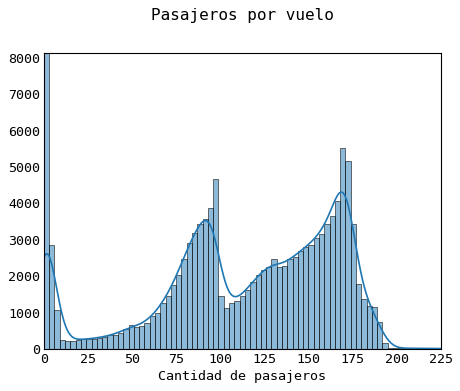

In [50]:
# Distribución de los pasajeros
sns.histplot(data=df2plt, stat='count', x='Pax', kde=True )
plt.title('Distribución de pasajeros por vuelo')
plt.xlabel('Cantidad de pasajeros por vuelo')
plt.title('Pasajeros por vuelo')
plt.xlabel('Cantidad de pasajeros')
plt.ylabel('')

La distribución de la cantidad de pasajeros por vuelo presenta 3 grupos bien definidos:
+ un grupo con muy poca cantidad de pasajeros (menos de 10)
+ otro grupo con vuelos que poseen menos de 100 pasajeros por vuelo
+ el último grupo con vuelos que poseen entre 100 y casi 200 pasajeros

#### Análisis de los retrasos

In [51]:

indicador = 'TD1'

retrasados = df[df['TD1'] > 0. ].copy() # Casos con retraso
dfR = df[df['TD1'] > Retraso[indicador]]

p_ret = round ((dfR.shape[0] / retrasados.shape[0])*100, 1)
p_ret_t = round ((dfR.shape[0] / df.shape[0])*100, 1)

print(f'Un {p_ret_t}% de los vuelos totales se retrasan más de {Retraso[indicador]} minutos,',
      f'\n mientras que un {p_ret} % de los vuelos RETRASADOS están demorados más de {Retraso[indicador]} minutos')

Un 8.2% de los vuelos totales se retrasan más de 25.5 minutos, 
 mientras que un 32.8 % de los vuelos RETRASADOS están demorados más de 25.5 minutos


#### Análisis de lo retrasos en función del lugar de origen

In [52]:
#Antes de responder esta pregunta, acotaremos la mirada sobre aquellos lugares con cierto mínimo de observaciones, sea 200.
selec = df.groupby(['Origen']).size()#.sort_values(ascending=False)
selec = selec[selec > 200]

tabla_freq = dfR.groupby('Origen').size() / df.groupby('Origen').size()

#me quedo con las filas de city tabla_freq que están en selec
tabla_freq = tabla_freq[tabla_freq.index.isin(selec.index)]

tabla_freq.sort_values(ascending=False, inplace=True)

tabla_freq = tabla_freq.to_frame().reset_index()
tabla_freq.columns = ['Origen', '% retrasos']

#Agregamos la información de la ciudad y el país
tabla_freq = tabla_freq.merge(df[['Origen', 'city', 'country', 'lat', 'lon']], on='Origen', how='left')
tabla_freq = tabla_freq.drop_duplicates(subset=['Origen'])

tabla_freq.head(20)

,Origen,% retrasos,city,country,lat,lon
0,AEP,0.52,Buenos Aires,Argentina,-34.56,-58.42
455,EZE,0.21,Buenos Aires,Argentina,-34.82,-58.54
1745,PMY,0.13,Puerto Madryn,Argentina,-42.76,-65.10
2487,PMQ,0.10,Perito Moreno,Argentina,-46.54,-70.98
2700,FMA,0.10,Formosa,Argentina,-26.21,-58.23
3945,USH,0.10,Ushuaia,Argentina,-54.84,-68.30
9090,JUJ,0.10,San Salvador de Jujuy,Argentina,-24.39,-65.10
12258,AFA,0.10,San Rafael,Argentina,-34.59,-68.40
13028,SCL,0.10,Santiago de Chile,Chile,-33.39,-70.79
15221,BRC,0.09,San Carlos de Bariloche,Argentina,-41.15,-71.16


In [53]:
# Distribución geográfica de los retrasos cuantificada en porcentaje.
fig = scatter1 = px.scatter_geo(tabla_freq,
                          lon='lon',
                          lat='lat',
                          color='% retrasos',
                          color_continuous_scale='jet',
                          opacity=0.9,
                          labels={'color': 'distancia (km)'},
                          #size = np.log10(df2pltgeo['TD1p'] + 1)
                          size = '% retrasos'
                          )
fig.update_geos(fitbounds="locations")  # Adjust the map bounds to fit the data
fig.update_layout(
    title = 'Ubicación geográfica de los aeropuertos con destino a AEP que presentan mayor retraso. <br> Los colores y tamaños corresponden al porcentaje de retraso'
)
fig.show()


Dejando a un lado los vuelos que despegan y aterrizan en Buenos Aires, ya que no se trata en general de vuelos comerciales con muchos pasajeros, vemos que Puerto Madryn es el lugar de origen con mayores demoras entre el horario programado y el horario en el que arribó el vuelo. Sin embargo, no se observa una marcada diferencia en alguna de las localizaciones en particular.

In [54]:
#@title PRESENTACIÓN: Retrasos en Argentina

## Geopandas
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) #un archivo para poder graficar el mundo
#
##world[world.name == 'Argentina'].plot(color='white', edgecolor='black')
##gdf = geopandas.GeoDataFrame(tabla_freq,
##                             geometry=geopandas.points_from_xy(tabla_freq.lon, tabla_freq.lat) #para generar un array geometrico teniendo en cuenta latitud y longitud
##    )
#
#ax = world[world.name == 'Argentina'].plot(color='white', edgecolor='black')
#
#gdf.plot(ax=ax, color='blue') #gdf era el elemento con nuestros puntos
#
#plt.show()

# Folium
folium_hmap = folium.Map(location=[-31, -64],
                         width="%100",
                         height="%100",
                         zoom_start=5,
                         tiles="OpenStreetMap")

hm_wide = HeatMap(list(zip(tabla_freq['lat'], tabla_freq['lon'], tabla_freq['% retrasos'])))

folium_hmap.add_child(hm_wide)

In [55]:
#veamos solamente AEP y EZE
bsas = df[df['Origen'].isin(['EZE', 'AEP'])]

# Aeroparque y Ezeiza:
print('Resumen de "Pax" en vuelos con despegue y arribo en Buenos Aires:')
bsas.Pax.describe()

Resumen de "Pax" en vuelos con despegue y arribo en Buenos Aires:


count   1745.00
mean       3.03
std       19.01
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      193.00
Name: Pax, dtype: float64

### Retrasos por aerolínea

In [56]:
selecc = df.groupby(['Aero']).size()
selecc = selecc[selecc > 200]

tabla_fre = dfR.groupby('Aero').size() / df.groupby('Aero').size()

#me quedo con las filas de Aero tabla_freq que están en selec
tabla_fre = tabla_fre[tabla_fre.index.isin(selecc.index)]

tabla_fre.sort_values(ascending=False, inplace=True)

tabla_fre = tabla_fre.to_frame().reset_index()
tabla_fre.columns = ['Aero', f'% Retrasos ({Retraso[indicador]} min+)']

tabla_fre.head(20)

,Aero,% Retrasos (25.5 min+)
0,OY,0.29
1,AJ,0.23
2,JA,0.21
3,FQ,0.20
4,FO,0.13
5,4M,0.10
6,WJ,0.10
7,AU,0.08
8,LA,0.08
9,AR,0.07


A diferencia de los lugares de origen, las distintas aerolíneas sí parecen presentar diferencias en los retrasos. Las que más demoras tuvieron fueron:

**Andes (OY)**;  Aero Contractors (AJ), que parece hacer vuelos con pocos pasajeros; **JetSMART (JA)**; Thomas Cook Airlines (FQ), también con pocos pasajeros; y **Flybondi (FO)**.

Las aerolíneas más confiables, a juzgar por el porcentaje de retrasos, son: Aerochaco (PRV) y Skyfly (H2). Esta última operó muy poco en Aeroparque (0,18% de los arribos, contra 8% Aerochaco)

In [57]:
print('Aero Contractors - Resumen de Pax \n')
display(df[df['Aero'] == 'AJ'].Pax.describe())

print('\nThomas Cook Airlines - Resumen de Pax \n')
df[df['Aero'] == 'FQ'].Pax.describe()

Aero Contractors - Resumen de Pax 



count   743.00
mean     18.22
std      19.01
min       0.00
25%       0.00
50%      12.00
75%      34.00
max     174.00
Name: Pax, dtype: float64


Thomas Cook Airlines - Resumen de Pax 



count   361.00
mean     19.31
std      19.22
min       0.00
25%       5.00
50%      15.00
75%      30.00
max     156.00
Name: Pax, dtype: float64

### Correlaciones - análisis

In [58]:
#@title Correlaciones

display(df.columns)
col2analize = ['Pax', 'lat', 'lon', 'max_cap', 'dist', 'TD1', 'TD2', 'TD3']
df2analize = df#[col2analize]

# Correlación de Pearson
correlation_pearson = df2analize.corr(method='pearson')
correlation_pearson

Index(['Aero', '#Vuelo', 'Origen', 'STA', 'ETA', 'ATA', 'Tipo', 'Pos', 'Ter',
       'Sec', 'Rmk', 'Cin', 'Pax', 'Mat', 'Acft', '#Rot', 'Cabecera', 'año',
       'mes', 'hora', 'country', 'city', 'lat', 'lon', 'max_cap', 'uso',
       'Clima', 'fuente', 'Dia_Semana', 'D_M_A', 'dist', 'TD1', 'TD2', 'TD3'],
      dtype='object')

<ipython-input-58-a3e3f23b91f7>:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Cin,Pax,Cabecera,año,mes,hora,lat,lon,max_cap,Clima,Dia_Semana,dist,TD1,TD2,TD3
Cin,1.00,0.51,0.05,0.00,0.00,0.03,-0.08,-0.16,0.47,-0.01,0.01,0.00,0.02,0.01,-0.00
Pax,0.51,1.00,0.06,0.09,0.01,0.04,-0.13,-0.18,0.82,-0.00,0.03,0.09,0.01,0.01,-0.01
Cabecera,0.05,0.06,1.00,-0.04,-0.02,-0.05,-0.01,-0.01,0.09,-0.06,-0.04,-0.01,-0.01,-0.00,-0.00
año,0.00,0.09,-0.04,1.00,-0.03,-0.03,0.06,0.01,0.01,0.06,0.01,0.05,-0.00,-0.00,0.00
mes,0.00,0.01,-0.02,-0.03,1.00,0.00,-0.00,-0.03,-0.03,0.02,-0.00,0.01,0.00,0.01,-0.00
hora,0.03,0.04,-0.05,-0.03,0.00,1.00,0.00,0.02,0.02,-0.03,0.02,-0.00,0.02,0.03,-0.02
lat,-0.08,-0.13,-0.01,0.06,-0.00,0.00,1.00,0.57,-0.14,0.01,-0.01,0.30,-0.01,-0.01,0.00
lon,-0.16,-0.18,-0.01,0.01,-0.03,0.02,0.57,1.00,-0.17,-0.00,-0.02,0.49,-0.02,-0.01,0.00
max_cap,0.47,0.82,0.09,0.01,-0.03,0.02,-0.14,-0.17,1.00,-0.00,0.04,0.06,0.00,0.00,-0.00
Clima,-0.01,-0.00,-0.06,0.06,0.02,-0.03,0.01,-0.00,-0.00,1.00,-0.01,0.00,0.06,0.03,-0.00


In [59]:
# Correlación de Spearman
correlation_spearman = df2analize.corr(method='spearman')
correlation_spearman

<ipython-input-59-69a9e93cef50>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Cin,Pax,Cabecera,año,mes,hora,lat,lon,max_cap,Clima,Dia_Semana,dist,TD1,TD2,TD3
Cin,1.00,0.46,0.05,-0.00,0.00,0.03,-0.03,-0.20,0.48,-0.01,0.01,0.12,-0.07,-0.08,0.01
Pax,0.46,1.00,0.04,0.13,0.02,0.03,-0.03,-0.27,0.73,-0.00,0.02,0.36,0.04,0.02,0.03
Cabecera,0.05,0.04,1.00,-0.04,-0.02,-0.07,-0.01,-0.01,0.06,-0.06,-0.04,0.01,-0.01,-0.02,0.03
año,-0.00,0.13,-0.04,1.00,-0.06,-0.01,0.07,-0.02,0.00,0.06,0.01,0.10,-0.01,0.01,-0.02
mes,0.00,0.02,-0.02,-0.06,1.00,0.00,-0.01,-0.04,-0.02,0.02,-0.00,0.01,0.03,0.03,-0.01
hora,0.03,0.03,-0.07,-0.01,0.00,1.00,0.01,-0.00,0.02,-0.03,0.03,0.00,0.06,0.05,0.02
lat,-0.03,-0.03,-0.01,0.07,-0.01,0.01,1.00,0.56,-0.03,0.01,-0.01,-0.13,-0.03,-0.03,0.03
lon,-0.20,-0.27,-0.01,-0.02,-0.04,-0.00,0.56,1.00,-0.25,-0.00,-0.03,-0.46,-0.04,-0.02,-0.02
max_cap,0.48,0.73,0.06,0.00,-0.02,0.02,-0.03,-0.25,1.00,-0.00,0.03,0.31,-0.06,-0.08,0.03
Clima,-0.01,-0.00,-0.06,0.06,0.02,-0.03,0.01,-0.00,-0.00,1.00,-0.01,0.00,0.06,0.05,0.03


In [60]:
# Correlación Parcial
xcol = ['TD1']
ycol = ['Clima']
#ycol = xcol
lala = pg.partial_corr(data=df, x = xcol, y = ycol, covar = 'TD3')
correlation_partial = df2analize.pcorr()
display(correlation_partial)

display(lala)

/usr/local/lib/python3.10/dist-packages/pingouin/correlation.py:952: FutureWarning:

The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Cin,Pax,Cabecera,año,mes,hora,lat,lon,max_cap,Clima,Dia_Semana,dist,TD1,TD2,TD3
Cin,1.00,0.24,0.02,-0.04,-0.00,0.02,0.04,-0.07,0.10,-0.00,-0.00,-0.01,0.02,0.01,0.01
Pax,0.24,1.00,-0.01,0.15,0.05,0.03,-0.01,-0.10,0.76,-0.01,-0.01,0.12,0.01,0.01,0.00
Cabecera,0.02,-0.01,1.00,-0.03,-0.02,-0.06,-0.00,0.01,0.06,-0.06,-0.04,-0.01,-0.00,-0.00,-0.01
año,-0.04,0.15,-0.03,1.00,-0.04,-0.03,0.06,-0.02,-0.11,0.06,0.01,0.02,-0.01,-0.01,-0.00
mes,-0.00,0.05,-0.02,-0.04,1.00,-0.00,0.01,-0.04,-0.07,0.02,-0.00,0.02,0.00,0.00,-0.00
hora,0.02,0.03,-0.06,-0.03,-0.00,1.00,-0.01,0.04,-0.01,-0.04,0.02,-0.02,0.02,0.03,-0.00
lat,0.04,-0.01,-0.00,0.06,0.01,-0.01,1.00,0.48,-0.04,0.01,-0.01,0.04,-0.00,-0.00,-0.00
lon,-0.07,-0.10,0.01,-0.02,-0.04,0.04,0.48,1.00,0.01,-0.01,-0.02,0.43,-0.01,-0.00,-0.00
max_cap,0.10,0.76,0.06,-0.11,-0.07,-0.01,-0.04,0.01,1.00,0.01,0.03,0.00,-0.01,-0.01,-0.01
Clima,-0.00,-0.01,-0.06,0.06,0.02,-0.04,0.01,-0.01,0.01,1.00,-0.01,0.00,0.06,0.05,0.04


,n,r,CI95%,p-val
pearson,125587,0.06,"[0.05, 0.06]",0.00


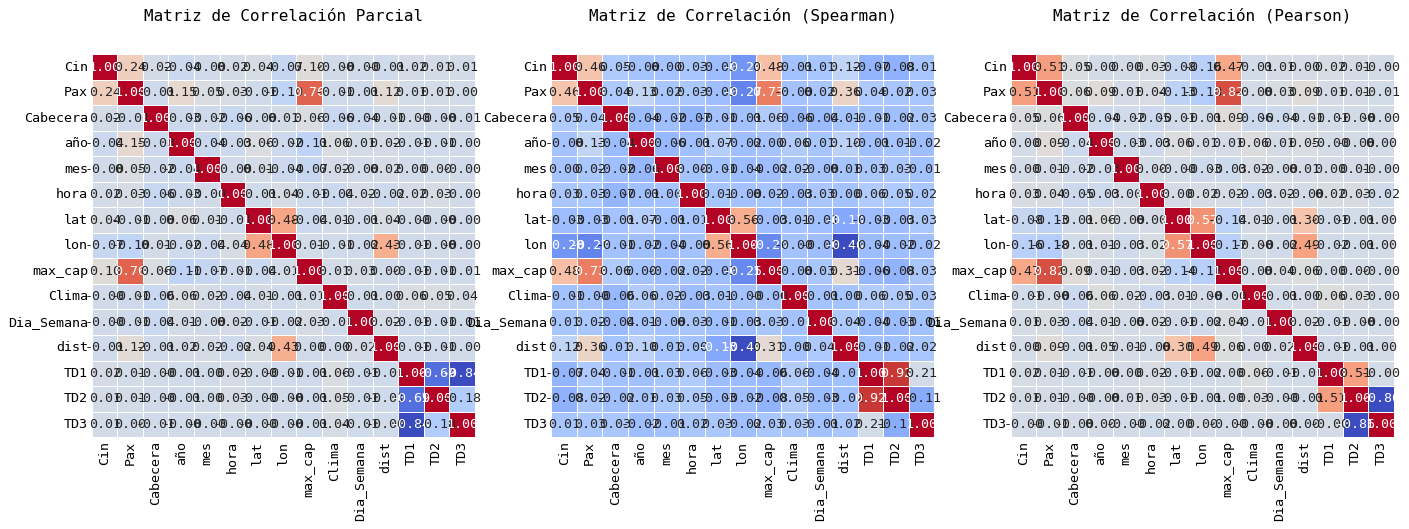

In [61]:
#@title Heatmap de las dos correlaciones para comparación visual directa

# uso de las distintas correlaciones
# src: https://kandadata.com/the-fundamental-differences-of-pearson-correlation-spearman-rank-kendall-tau-and-chi-square/

#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(21, 7))


#Para reorientar la barra, pero al final no se usa. Ídem para cbar_kws.
#cax = inset_axes(ax,
#  width="40%",  # width: 40% of parent_bbox width
#  height="10%",  # height: 10% of parent_bbox height
#  loc='lower left',
#  bbox_to_anchor=(0, 1.1, 1, 1),
#  bbox_transform=ax.transAxes,
#  borderpad=0,
#  )

# Heatmap para cada tipo de correlación
sns.heatmap(correlation_partial, cmap='coolwarm', cbar=False, annot=True, fmt=".2f", linewidths=0.5, ax = ax1, square=True)#, cbar_kws={'orientation': 'horizontal'}  )
sns.heatmap(correlation_spearman, cmap='coolwarm', cbar=False, annot=True, fmt=".2f", linewidths=0.5, ax = ax2, square=True )
sns.heatmap(correlation_pearson, cmap='coolwarm', cbar=False, annot=True, fmt=".2f", linewidths=0.5, ax = ax3, square=True )


#plt.subplots_adjust(bottom=0.8)

# # Add labels and title to the plot
ax1.set_title("Matriz de Correlación Parcial")
ax2.set_title("Matriz de Correlación (Spearman)")
ax3.set_title("Matriz de Correlación (Pearson)")


#fig.tight_layout()

plt.show()

Los heatmap de correlaciones no muestran correlaciones significativas entre las variables de estudio y las de objetivo (TD1, TD2 y TD3). Tener presente que como las distribuciones no corresponden a distribuciones normales, la correlación de Pearson no es representativa para el estudio de correlaciones. Las correlaciones de Spearman y la parcial son más significativas para analizar.

Entre las variables objetivos, se observa una fuerte correlación entre TD1 y TD2 en las tres correlaciones (positiva para las correlaciones estándar y negativa para la parcial). No obstante, en la correlación parcial es más significativa la anticorrelación entre TD1 y TD3 que con Spearman que es positiva. La correlación entre TD2 y TD3 sólo es significativa en Pearson (y es negativa).

Además se observa una correlación significativa entre la distancia a Aeroparque (dist) y la longitud del aeropuerto (lon) en las 3 correlaciones (positiva para la parcial y Pearson y negativa para Spearman).

Se evidencia la correlación directa entre la cantidad de pasajeros (Pax) y la capacidad máxima de los vuelos (max_cap).

Se observa que la incorporación del clima en comparación con las otras variables es apreciablemente significativa en la correlación parcial y de Pearson, no así en la de Spearman. No obstante no son significativas ya que su valor sigue siendo muy próximo a cero.

## 4. Encoding:

Pasar las variables categóricas (strings) a numéricas. Analizar diferentes métodos para elegir el
más adecuado (One hot encoding, Label encoding, Getdummies).

La mayoría de los Algoritmos de Machine Learning no soportan texto, o prefieren trabajar con variables numéricas. Por ello, se debe convertir las variables categóricas, pasando de tipo cualitativas (texto) a cuantitativas (número). A este procedimiento de lo conoce como Encoding.

##Clasificación de las variables

Variables Cuantitativas:
  * Continuas:
    * Pax
    * año
    * mes
    * hora
    * lat
    * lon
    

  * Discretas:
    * #Vuelo
    * Pos
    * Sec
    * Cin
    * #Rot
    * Cabecera
    * max_cap

Variables Cualitativas:
  * Nominales:
    * Aero
    * Origen
    * Tipo
    * Mat
    * Acft
    * Aero.1
    * country
    * city
    * uso


  * Ordinales:
    * STA
    * ETA
    * ATA
    * Ter
    * Rmk
    * Dia_semana (ya codificada)


Como vimos, parece que existen algunas aerolineas que tienen mas tendencia a presentar retrasos en el arribo, por lo tanto esta es una variable categórica a la cual realizarle un encoding.

In [62]:
# Cualitativas:
df.Aero.value_counts()

AR     64404
AU     18163
PRV     9722
4M      9563
WJ      6050
FO      5484
DN      4691
OY      1690
LA      1423
G3      1000
AJ       743
A0       654
Z7       450
ZP       425
FQ       361
JA       276
H2       232
5U       177
FAA       66
LP         5
VH         5
H8         2
USF        1
Name: Aero, dtype: int64

La cantidad de opciones que tiene esta variable es 23, por lo tanto utilizar OnHotEncoding generaría problemas de dimensionalidad y posible overfitting.

Elegimos trabajar con LabelEncoder, esta codificación asigna una etiqueta numérica única a cada opción.

In [63]:
categorical_col_1= df['Aero']

In [64]:

cat_encoder = LabelEncoder()
cat_1 = cat_encoder.fit_transform(categorical_col_1)

In [65]:
df_output_1 = pd.DataFrame(cat_1,
                         index=categorical_col_1.index,
                         columns=['Aero_encoder'])
df_output_1

,Aero_encoder
0,6
1,0
2,0
3,4
4,4
...,...
125582,20
125583,13
125584,20
125585,8


In [66]:
var='Acft'
selecc = df.groupby([var]).size()
selecc = selecc[selecc > 50]

tabla_fre = dfR.groupby(var).size() / df.groupby(var).size()

#me quedo con las filas de uso tabla_freq que están en selec
tabla_fre = tabla_fre[tabla_fre.index.isin(selecc.index)]

tabla_fre.sort_values(ascending=False, inplace=True)

tabla_fre = tabla_fre.to_frame().reset_index()
tabla_fre.columns = [var, f'% Retrasos ({Retraso[indicador]} min+)']

tabla_fre.head(10)

,Acft,% Retrasos (25.5 min+)
0,GR6,0.43
1,M83,0.31
2,M81,0.28
3,ER4,0.24
4,GR4,0.20
5,F900,0.18
6,E135,0.15
7,320N,0.13
8,321W,0.10
9,CR2,0.10


In [67]:
df.Acft.value_counts()

738W    48236
E190    30885
320     16965
737W     6352
7M8      4128
        ...  
BH2         1
312         1
ER3         1
PA28        1
TBM8        1
Name: Acft, Length: 122, dtype: int64

Como vemos, hay algunos modelos de aviones que tambien parecen tener relación con los retrasos, esto puede ser debido al equipamiento que estos posean y la capacidad que tengan para afrontar distintas condiciones que se puedan dar. Por lo tanto le aplicamos LabelEnconder.

In [68]:
categorical_col_2 = df['Acft']

In [69]:

cat_encoder = LabelEncoder()
cat_2 = cat_encoder.fit_transform(categorical_col_2)

In [70]:
df_output_2 = pd.DataFrame(cat_2,
                         index=categorical_col_2.index,
                          columns=['Acft_encoder'])
df_output_2

,Acft_encoder
0,13
1,4
2,4
3,14
4,14
...,...
125582,4
125583,5
125584,4
125585,14


In [71]:
#@title Añadir columnas al data frame
df = pd.concat([df, df_output_1, df_output_2], axis = 1)
df.head()

,Aero,#Vuelo,Origen,STA,ETA,ATA,Tipo,Pos,Ter,Sec,Rmk,Cin,Pax,Mat,Acft,#Rot,Cabecera,año,mes,hora,country,city,lat,lon,max_cap,uso,Clima,fuente,Dia_Semana,D_M_A,dist,TD1,TD2,TD3,Aero_encoder,Acft_encoder
0,DN,6049,IGR,2019-01-01 01:50:00,2019-01-01 01:22:00,2019-01-01 01:22:00,1 C P,31,A,2,ATE,8,100,LVHQH,738,6062,31.00,2019,1,1,Argentina,Puerto Iguazú,-25.74,-54.47,189,Transporte de pasajeros,0,NaN,1,2019-01-01,1048.83,-28.00,-28.00,0.00,6,13
1,4M,7623,COR,2019-01-01 06:17:00,2019-01-01 05:50:00,2019-01-01 06:02:00,1 C P,9,A,2,ATE,6,36,LVBFO,320,7502,31.00,2019,1,6,Argentina,Córdoba,-31.31,-64.21,195,Transporte de pasajeros,0,NaN,1,2019-01-01,650.36,-15.00,-27.00,12.00,0,4
2,4M,7653,MDZ,2019-01-01 07:37:00,2019-01-01 07:30:00,2019-01-01 07:30:00,1 C P,10,A,2,ATE,8,153,LVGLP,320,7550,13.00,2019,1,7,Argentina,Mendoza,-32.83,-68.79,195,Transporte de pasajeros,0,NaN,1,2019-01-01,980.62,-7.00,-7.00,0.00,0,4
3,AR,1671,NQN,2019-01-01 07:40:00,2019-01-01 07:29:00,2019-01-01 07:26:00,1 C P,7,A,2,ATE,1,28,LVFUA,738W,1672,13.00,2019,1,7,Argentina,Neuquén,-38.95,-68.16,189,Transporte de pasajeros,0,NaN,1,2019-01-01,996.10,-14.00,-11.00,-3.00,4,14
4,AR,1611,MDQ,2019-01-01 07:55:00,2019-01-01 07:45:00,2019-01-01 07:43:00,1 C P,26,A,2,ATE,2,146,LVGVA,738W,1496,13.00,2019,1,7,Argentina,Mar del Plata,-37.93,-57.57,189,Transporte de pasajeros,0,NaN,1,2019-01-01,382.02,-12.00,-10.00,-2.00,4,14


#5. Escalamiento de los datos:

Transformar las features para que tengan distribuciones más cercanas a la normal (elegir qué
método es más conveniente: logaritmica, normalizar, estandarizar). En el caso de usar PCA, este
paso debe realizarse posteriormente de aplicarlo, para que en las componentes PCA las variables
sean “pesadas” de manera similar, y no tenga alto impacto la varianza de las columnas originales

Lo que buscamos con estas transformaciones es intentar obtener distribuciones cercanas a la normal aplicando esto sobre las variables que tengan algun tipo de relación sobre los retrasos, con el objetivo de que cuando llegue la hora de aplicar los modelos de aprendizaje automático, estas variables de entrada tengan propiedades deseables para obtener mejores rendimientos y eficiencias en los modelos.

Es muy probable, que luego, cuando entrenemos el modelo haya que experimentar con otras técnicas para determinar cual es la mas adecuada.

El criterio para elegir una técnica en particular como la normalización o estandarización por ahora es la siguiente:

En base a analisis previos, se decide realizar:

* Normalización (escalamiento entre 0 y 1):
  * cin [0 9]
  * Dia_Semana [0 6]
  * Cabecera [13 y 31]

* Estandarización
  * Pax ($μ$: 112.6 y $σ$: 53.1)
  * dist ($μ$: 11.76.9 y  $σ$: 1061.6)


## Normalización

Para la normalización utilizaremos la función de sklearn 'MinMaxScaler que transforma la escala de los datos en un rango que va de 0 a 1 y mantiene la relación entre ellas, buscando evitar que los valores de gran tamaño dominen a los pequeños en los modelos de aprendizaje automatico.

In [72]:
min_max_scaler = MinMaxScaler()

In [73]:
df[['Cin_norm', 'Dia_Semana_norm', 'Cabecera_norm']] = min_max_scaler.fit_transform(df[['Cin', 'Dia_Semana', 'Cabecera']])

## Estandarización

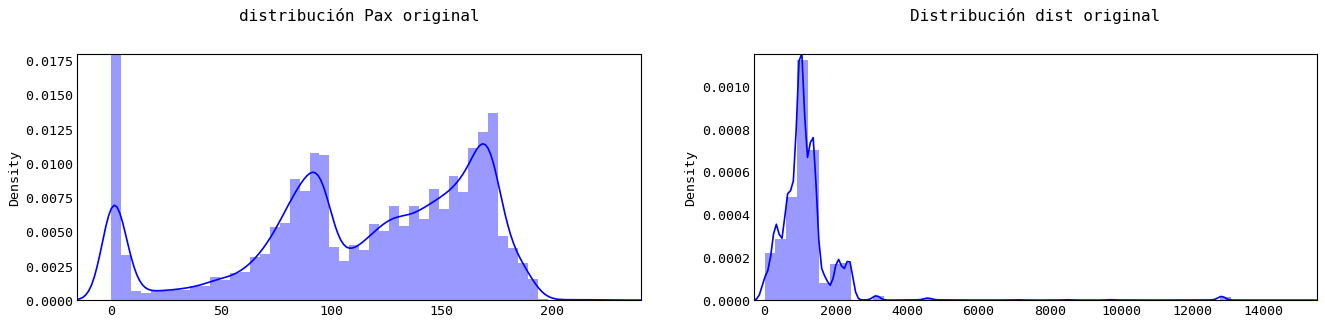

In [74]:
Pax= df[['Pax']]
dist= df[['dist']]

warnings.filterwarnings('ignore')
fig, ax=plt.subplots(1,2,figsize=(20,4))
sns.distplot(Pax, ax=ax[0], color='blue')
ax[0].set_title("distribución Pax original")

sns.distplot(dist, ax=ax[1],color='Blue')
ax[1].set_title('Distribución dist original')

plt.show()

Para estas dos variables vemos que hay dos tipos de distribuciones, una multimodal con 3 modas para el caso de la cantidad de pasajeros 'Pax' y para la distancia 'dist' vemos que la distribución es sesgada con cola a la derecha.


* Distribución sesgada con cola a la derecha:

Este tipo de distribución puede afectar negativamente el rendimiento y la generalización si la utilizamos en un modelo de aprendizaje automatico, ya que este aprendera mas sobre las categorias con mayor frecuencia y prestara menos atención a la parte baja de la distribución. Entonces es muy probable que cuando este en funcionamiento y reciba datos mas equilibrados no generalice correctamente.

Una solución es aplicar una transformación logaritmica, la cual es una técnica recomendada para estas distribuciones.

In [75]:
df['dist_log'] = np.log2(df.dist)

* Distribución multimodal

  Para este tipo de distribución vamos a utilizar la función 'StandarScaler que va a transformar los datos para que obtengamos una media de 0 y una desviación estandar de 1

In [76]:
scaler = StandardScaler()

In [77]:
df[['Pax_estandar']] = scaler.fit_transform(df[['Pax']])

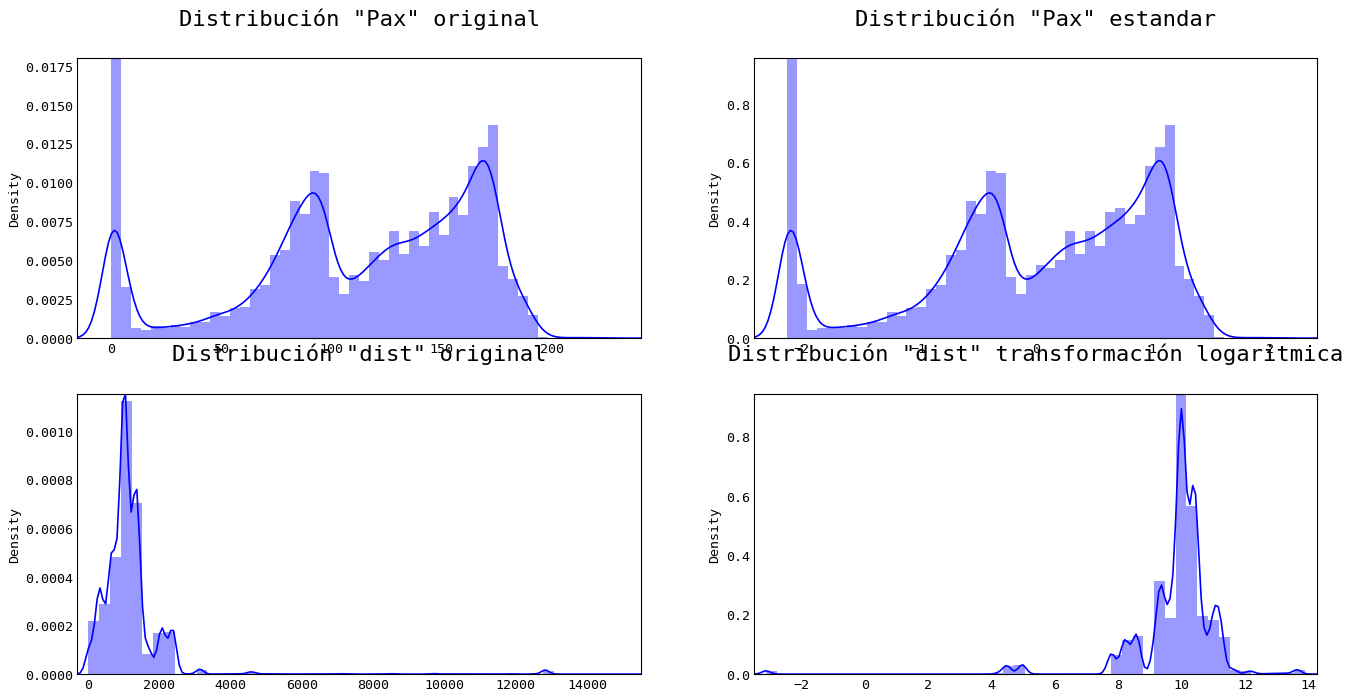

In [78]:
Pax= df[['Pax']]
dist= df[['dist']]
Pax_estandar= df[['Pax_estandar']]
dist_log= df[['dist_log']]

warnings.filterwarnings('ignore')
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.distplot(Pax, ax=ax[0,0],color='Blue')
ax[0,0].set_title('Distribución "Pax" original', fontsize = 20)

sns.distplot(Pax_estandar, ax=ax[0,1],color='Blue')
ax[0,1].set_title('Distribución "Pax" estandar', fontsize = 20)

sns.distplot(dist, ax=ax[1,0],color='Blue')
ax[1,0].set_title('Distribución "dist" original', fontsize = 20)

sns.distplot(dist_log, ax=ax[1,1],color='Blue')
ax[1,1].set_title('Distribución "dist" transformación logaritmica', fontsize = 20)

plt.show()

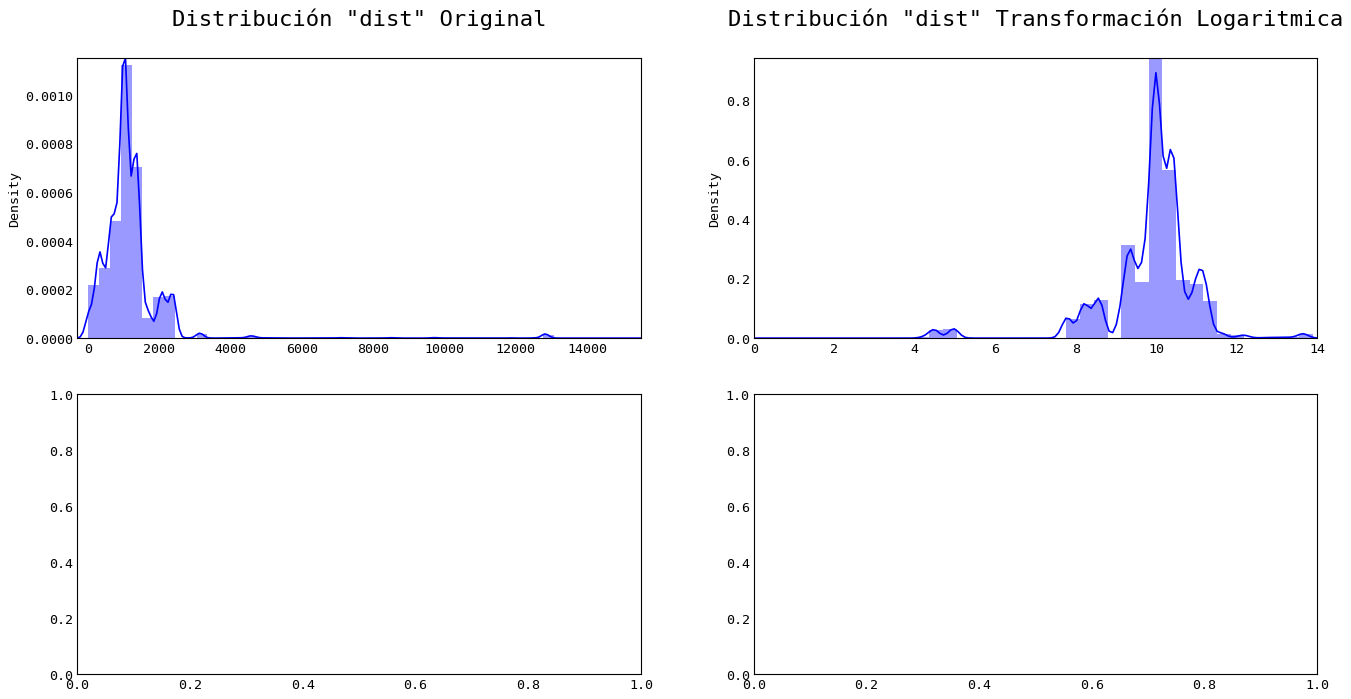

In [79]:

warnings.filterwarnings('ignore')
fig, ax=plt.subplots(2,2,figsize=(20,10))

sns.distplot(dist, ax=ax[0,0],color='Blue')
ax[0,0].set_title('Distribución "dist" Original', fontsize = 20)

sns.distplot(dist_log, ax=ax[0,1],color='Blue')
ax[0,1].set_title('Distribución "dist" Transformación Logaritmica', fontsize = 20)
ax[0,1].set_xlim(0,14)

plt.show()

In [81]:
# guardamos en el drive el DB
with open(path+'db-TP2.csv', 'w') as f:
  df.to_csv(f, index=False)